Comprehensive Validation Suite for Pore Pressure Prediction
===========================================================


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

In [ ]:
print("\nLoading datasets...")

train_file = './test_df_data.csv'
test_file = './test_data.csv'

df_train = pd.read_csv(train_file)
df_test = pd.read_csv(test_file) if test_file else None

print(f"Training samples: {len(df_train):,}")
if df_test is not None:
    print(f"Test samples: {len(df_test):,}")

# Define features
core_features = ['tvd', 'gr', 'dt', 'dt_nct', 'rhob_combined', 
                    'res_deep', 'phie', 'ob', 'hp', 'temp']
engineered_features = ['delta_dt', 'dt_ratio', 'ai', 'eff_stress_proxy',
                        'dt_gradient', 'rhob_gradient', 'gr_gradient']

# Filter to available features
available_features = [f for f in core_features + engineered_features 
                        if f in df_train.columns]

print(f"\nAvailable features: {len(available_features)}")

# Run validation suite
results = {}


Loading datasets...
Training samples: 224,546
Test samples: 45,359

Available features: 17


## 1. MULTICOLLINEARITY ANALYSIS (VIF)

In [2]:
def calculate_vif(df, features, max_iter=3):
    """
    Calculate VIF with iterative removal of highly collinear features
    
    INTERPRETATION:
    - VIF < 5: Low multicollinearity (good)
    - VIF 5-10: Moderate (acceptable for trees, concerning for linear models)  
    - VIF > 10: High multicollinearity (problematic)
    - VIF = inf: Perfect multicollinearity (must remove)
    """
    print("="*80)
    print("MULTICOLLINEARITY ANALYSIS - Variance Inflation Factor (VIF)")
    print("="*80)
    
    features_to_check = features.copy()
    removed_features = []
    
    for iteration in range(max_iter):
        print(f"\nIteration {iteration + 1}")
        print("-"*40)
        
        # Prepare data
        X = df[features_to_check].dropna()
        
        # Standardize for VIF calculation
        scaler = StandardScaler()
        X_scaled = pd.DataFrame(
            scaler.fit_transform(X),
            columns=X.columns,
            index=X.index
        )
        
        # Calculate VIF
        vif_data = pd.DataFrame()
        vif_data["Feature"] = X_scaled.columns
        vif_data["VIF"] = [
            variance_inflation_factor(X_scaled.values, i) 
            for i in range(X_scaled.shape[1])
        ]
        vif_data = vif_data.sort_values('VIF', ascending=False)
        
        print("\nVIF Results:")
        for _, row in vif_data.iterrows():
            vif_val = row['VIF']
            if np.isinf(vif_val):
                status = "🔴 PERFECT COLLINEARITY"
            elif vif_val > 10:
                status = "⚠️  HIGH"
            elif vif_val > 5:
                status = "⚡ MODERATE"
            else:
                status = "✅ LOW"
            print(f"{row['Feature']:20}: {vif_val:10.2f} {status}")
        
        # Remove worst offender if VIF > 10
        worst_feature = vif_data.iloc[0]
        if worst_feature['VIF'] > 10:
            print(f"\n🔴 Removing '{worst_feature['Feature']}' (VIF = {worst_feature['VIF']:.2f})")
            features_to_check.remove(worst_feature['Feature'])
            removed_features.append(worst_feature['Feature'])
        else:
            break
    
    print(f"\n{'='*40}")
    print(f"Features removed due to multicollinearity: {removed_features}")
    print(f"Remaining features: {len(features_to_check)}")
    
    # Correlation heatmap for remaining features
    plt.figure(figsize=(12, 10))
    correlation_matrix = df[features_to_check].corr()
    mask = np.triu(np.ones_like(correlation_matrix), k=1)
    sns.heatmap(correlation_matrix, mask=mask, annot=True, fmt='.2f', 
                cmap='coolwarm', center=0, vmin=-1, vmax=1,
                cbar_kws={'label': 'Correlation'})
    plt.title('Feature Correlation Matrix (After VIF Filtering)', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    return features_to_check, vif_data, removed_features


MULTICOLLINEARITY ANALYSIS - Variance Inflation Factor (VIF)

Iteration 1
----------------------------------------

VIF Results:
hp                  :        inf 🔴 PERFECT COLLINEARITY
ob                  :        inf 🔴 PERFECT COLLINEARITY
dt                  :        inf 🔴 PERFECT COLLINEARITY
dt_nct              :        inf 🔴 PERFECT COLLINEARITY
eff_stress_proxy    :        inf 🔴 PERFECT COLLINEARITY
delta_dt            :        inf 🔴 PERFECT COLLINEARITY
tvd                 :   72410.98 ⚠️  HIGH
dt_ratio            :     117.08 ⚠️  HIGH
ai                  :      27.32 ⚠️  HIGH
rhob_combined       :      14.26 ⚠️  HIGH
dt_gradient         :       8.37 ⚡ MODERATE
rhob_gradient       :       8.35 ⚡ MODERATE
phie                :       7.16 ⚡ MODERATE
gr                  :       2.70 ✅ LOW
temp                :       1.83 ✅ LOW
gr_gradient         :       1.08 ✅ LOW
res_deep            :       1.03 ✅ LOW

🔴 Removing 'hp' (VIF = inf)

Iteration 2
-------------------------------------

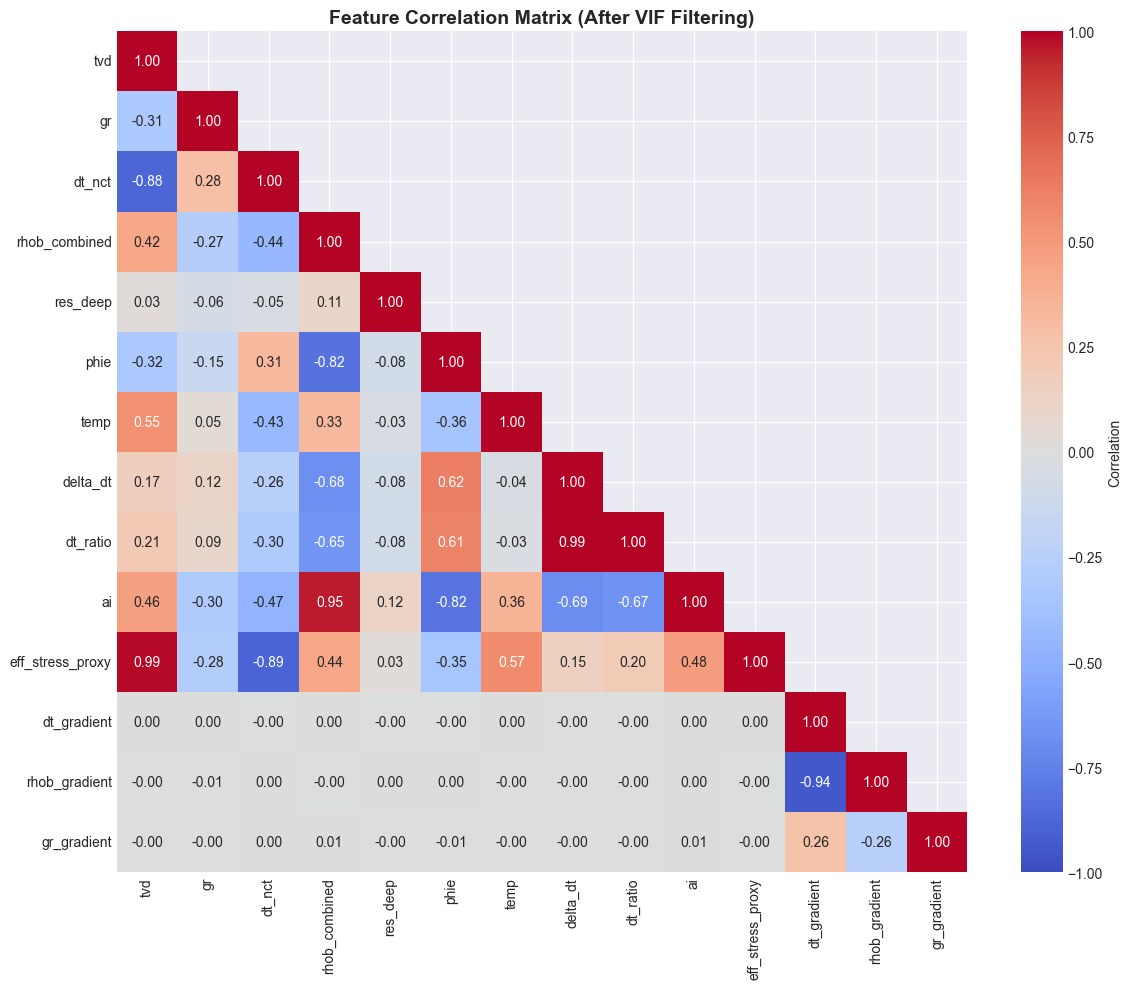

In [11]:
selected_features, vif_results, removed = calculate_vif(
    df_train, available_features
)
results['selected_features'] = selected_features
results['vif_removed'] = removed

## 2. DOMAIN SHIFT QUANTIFICATION

In [3]:
def analyze_domain_shift(df_train, df_test, features):
    """
    Quantify distribution shift between train and test sets
    
    INTERPRETATION:
    - KS statistic > 0.3: Large shift (problematic)
    - KS p-value < 0.05: Statistically significant shift
    - Large shifts require domain adaptation strategies
    """
    print("\n" + "="*80)
    print("DOMAIN SHIFT ANALYSIS - Kolmogorov-Smirnov Test")
    print("="*80)
    
    shift_results = []
    
    for feature in features:
        if feature in df_train.columns and feature in df_test.columns:
            # Remove NaN values
            train_vals = df_train[feature].dropna()
            test_vals = df_test[feature].dropna()
            
            # KS test
            ks_stat, p_value = stats.ks_2samp(train_vals, test_vals)
            
            # Effect size (normalized by combined std)
            train_mean, train_std = train_vals.mean(), train_vals.std()
            test_mean, test_std = test_vals.mean(), test_vals.std()
            pooled_std = np.sqrt((train_std**2 + test_std**2) / 2)
            effect_size = abs(train_mean - test_mean) / pooled_std if pooled_std > 0 else 0
            
            shift_results.append({
                'Feature': feature,
                'KS_Statistic': ks_stat,
                'P_Value': p_value,
                'Effect_Size': effect_size,
                'Train_Mean': train_mean,
                'Test_Mean': test_mean,
                'Mean_Shift_%': abs(train_mean - test_mean) / abs(train_mean) * 100 if train_mean != 0 else 0
            })
    
    shift_df = pd.DataFrame(shift_results).sort_values('KS_Statistic', ascending=False)
    
    print("\nDomain Shift Summary:")
    print("-"*80)
    for _, row in shift_df.iterrows():
        severity = "🔴 SEVERE" if row['KS_Statistic'] > 0.3 else "⚠️  MODERATE" if row['KS_Statistic'] > 0.15 else "✅ MILD"
        print(f"{row['Feature']:20}: KS={row['KS_Statistic']:.3f}, p={row['P_Value']:.3e}, "
              f"Mean shift={row['Mean_Shift_%']:.1f}% {severity}")
    
    # Visualize top shifted features
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()
    
    top_shifted = shift_df.head(6)
    for idx, (_, row) in enumerate(top_shifted.iterrows()):
        feature = row['Feature']
        ax = axes[idx]
        
        # Plot distributions
        ax.hist(df_train[feature].dropna(), bins=50, alpha=0.6, label='Train', density=True, color='blue')
        ax.hist(df_test[feature].dropna(), bins=50, alpha=0.6, label='Test', density=True, color='red')
        ax.set_xlabel(feature)
        ax.set_ylabel('Density')
        ax.set_title(f'{feature}\nKS={row["KS_Statistic"]:.3f}', fontweight='bold')
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    plt.suptitle('Top 6 Features with Domain Shift', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # Overall shift assessment
    severe_shift_count = (shift_df['KS_Statistic'] > 0.3).sum()
    print(f"\n{'='*40}")
    print(f"DOMAIN SHIFT SEVERITY ASSESSMENT:")
    print(f"  - Features with SEVERE shift (KS > 0.3): {severe_shift_count}/{len(shift_df)}")
    print(f"  - Average KS statistic: {shift_df['KS_Statistic'].mean():.3f}")
    
    if shift_df['KS_Statistic'].mean() > 0.2:
        print("\n⚠️  RECOMMENDATION: Significant domain shift detected!")
        print("   Consider: 1) Domain adaptation networks")
        print("            2) Importance weighting")
        print("            3) Adversarial training")
    
    return shift_df



DOMAIN SHIFT ANALYSIS - Kolmogorov-Smirnov Test

Domain Shift Summary:
--------------------------------------------------------------------------------
phie                : KS=0.385, p=0.000e+00, Mean shift=48.7% 🔴 SEVERE
temp                : KS=0.300, p=0.000e+00, Mean shift=15.4% ⚠️  MODERATE
rhob_combined       : KS=0.266, p=0.000e+00, Mean shift=0.2% ⚠️  MODERATE
ai                  : KS=0.215, p=0.000e+00, Mean shift=9.3% ⚠️  MODERATE
gr                  : KS=0.182, p=0.000e+00, Mean shift=17.2% ⚠️  MODERATE
dt_nct              : KS=0.162, p=0.000e+00, Mean shift=4.2% ⚠️  MODERATE
delta_dt            : KS=0.151, p=0.000e+00, Mean shift=39.5% ⚠️  MODERATE
dt_ratio            : KS=0.143, p=0.000e+00, Mean shift=4.4% ✅ MILD
res_deep            : KS=0.132, p=0.000e+00, Mean shift=20.1% ✅ MILD
eff_stress_proxy    : KS=0.101, p=0.000e+00, Mean shift=2.1% ✅ MILD
dt_gradient         : KS=0.082, p=7.383e-222, Mean shift=77.6% ✅ MILD
rhob_gradient       : KS=0.082, p=2.660e-219, Mean shi

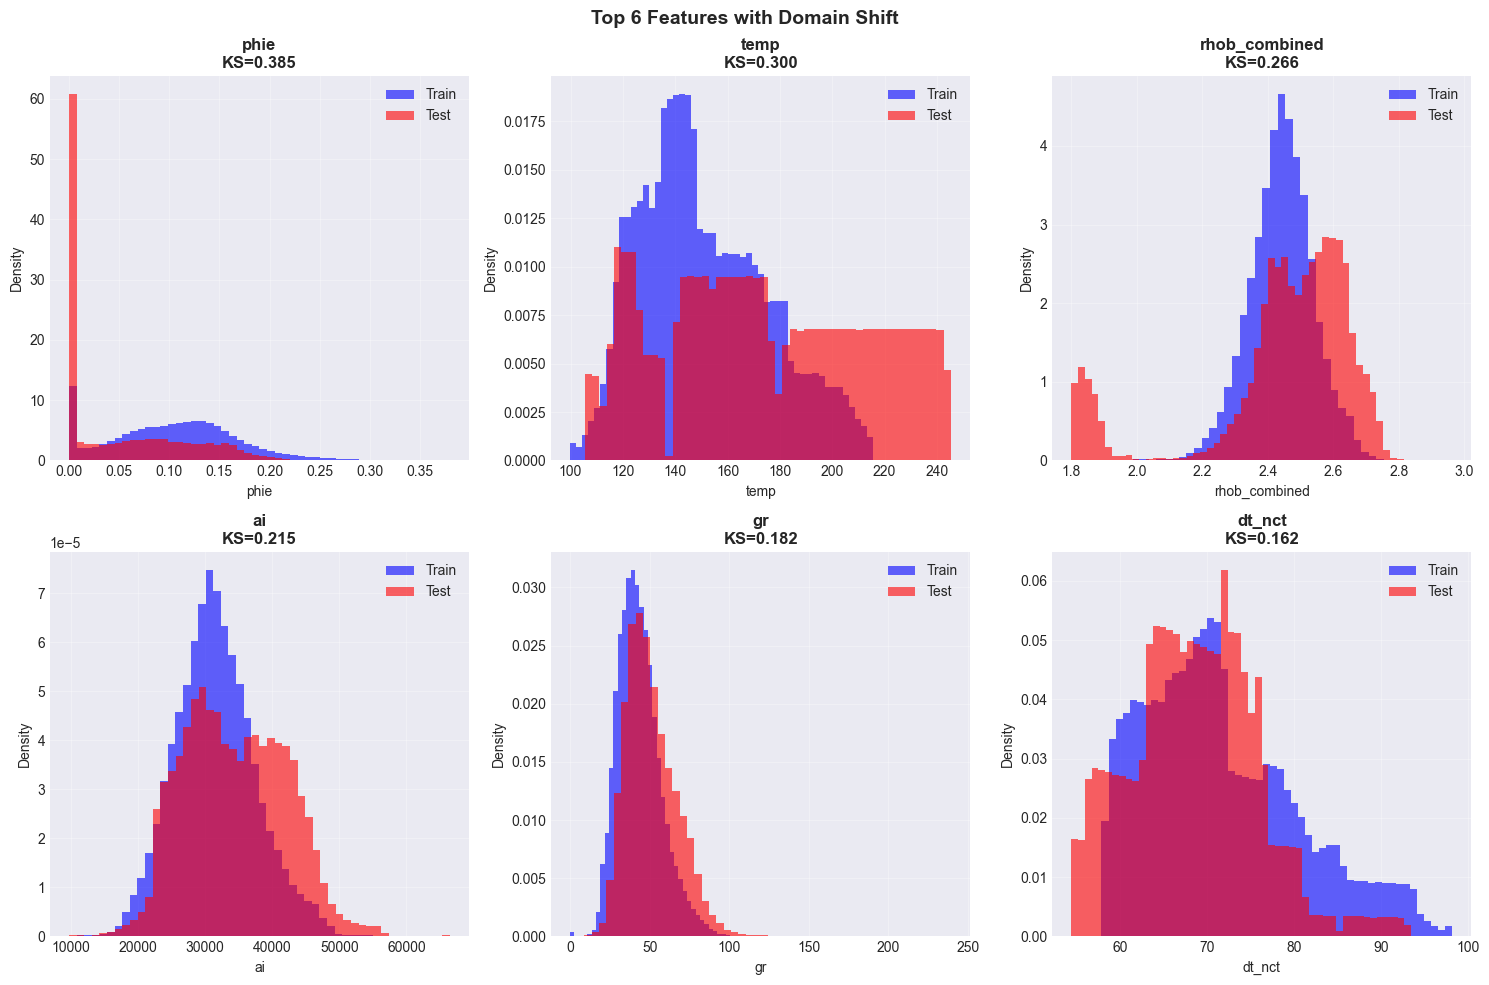


DOMAIN SHIFT SEVERITY ASSESSMENT:
  - Features with SEVERE shift (KS > 0.3): 1/14
  - Average KS statistic: 0.165


In [ ]:
if df_test is not None:
    shift_results = analyze_domain_shift(df_train, df_test, selected_features)
    results['domain_shift'] = shift_results

## 3. FEATURE-TARGET CORRELATION ANALYSIS

In [4]:
def analyze_feature_target_correlation(df, features, target='ppp'):
    """
    Analyze feature correlations with target and identify potential leakage
    
    INTERPRETATION:
    - |correlation| > 0.9: Potential target leakage
    - |correlation| > 0.7: Strong predictor
    - |correlation| < 0.1: Weak predictor
    """
    print("\n" + "="*80)
    print("FEATURE-TARGET CORRELATION ANALYSIS")
    print("="*80)
    
    correlations = []
    for feature in features:
        if feature in df.columns:
            # Pearson correlation
            pearson_corr = df[feature].corr(df[target])
            
            # Spearman correlation (non-linear relationships)
            spearman_corr = df[feature].corr(df[target], method='spearman')
            
            # Mutual information (non-linear dependency)
            from sklearn.feature_selection import mutual_info_regression
            X = df[[feature]].dropna()
            y = df.loc[X.index, target]
            mask = ~(X.isna().any(axis=1) | y.isna())
            if mask.sum() > 100:  # Need sufficient samples
                mi_score = mutual_info_regression(X[mask], y[mask], random_state=42)[0]
            else:
                mi_score = np.nan
            
            correlations.append({
                'Feature': feature,
                'Pearson': pearson_corr,
                'Spearman': spearman_corr,
                'Mutual_Info': mi_score,
                'Abs_Pearson': abs(pearson_corr)
            })
    
    corr_df = pd.DataFrame(correlations).sort_values('Abs_Pearson', ascending=False)
    
    print("\nFeature-Target Correlations:")
    print("-"*80)
    for _, row in corr_df.iterrows():
        warning = "⚠️  LEAKAGE?" if abs(row['Pearson']) > 0.9 else ""
        print(f"{row['Feature']:20}: Pearson={row['Pearson']:+.3f}, "
              f"Spearman={row['Spearman']:+.3f}, MI={row['Mutual_Info']:.3f} {warning}")
    
    # Visualize
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # Bar plot of correlations
    ax = axes[0]
    colors = ['red' if abs(x) > 0.9 else 'orange' if abs(x) > 0.7 else 'green' 
              for x in corr_df['Pearson']]
    ax.barh(range(len(corr_df)), corr_df['Pearson'], color=colors)
    ax.set_yticks(range(len(corr_df)))
    ax.set_yticklabels(corr_df['Feature'])
    ax.set_xlabel('Pearson Correlation with PPP')
    ax.set_title('Feature-Target Correlations', fontweight='bold')
    ax.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
    ax.grid(True, alpha=0.3)
    
    # Scatter plots of top correlators
    ax = axes[1]
    top_features = corr_df.head(3)['Feature'].tolist()
    for i, feat in enumerate(top_features):
        sample_data = df[[feat, target]].sample(min(1000, len(df)))
        ax.scatter(sample_data[feat], sample_data[target], alpha=0.3, s=10, label=feat)
    ax.set_xlabel('Feature Value (normalized)')
    ax.set_ylabel('PPP (psi)')
    ax.set_title('Top 3 Correlated Features vs Target', fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Check for target leakage
    leakage_features = corr_df[corr_df['Abs_Pearson'] > 0.9]['Feature'].tolist()
    if leakage_features:
        print(f"\n🔴 WARNING: Potential target leakage in features: {leakage_features}")
        print("   These features have suspiciously high correlation with target!")
    
    return corr_df



FEATURE-TARGET CORRELATION ANALYSIS

Feature-Target Correlations:
--------------------------------------------------------------------------------
tvd                 : Pearson=+0.893, Spearman=+0.895, MI=2.177 
eff_stress_proxy    : Pearson=+0.873, Spearman=+0.878, MI=2.179 
dt_nct              : Pearson=-0.841, Spearman=-0.849, MI=2.093 
dt_ratio            : Pearson=+0.494, Spearman=+0.541, MI=0.311 
delta_dt            : Pearson=+0.443, Spearman=+0.490, MI=0.301 
temp                : Pearson=+0.353, Spearman=+0.364, MI=1.942 
gr                  : Pearson=-0.277, Spearman=-0.286, MI=0.185 
ai                  : Pearson=+0.161, Spearman=+0.196, MI=0.154 
rhob_combined       : Pearson=+0.147, Spearman=+0.183, MI=0.157 
phie                : Pearson=-0.034, Spearman=-0.048, MI=0.114 
res_deep            : Pearson=-0.016, Spearman=-0.002, MI=0.254 
dt_gradient         : Pearson=-0.002, Spearman=-0.013, MI=0.045 
rhob_gradient       : Pearson=+0.002, Spearman=+0.014, MI=0.050 
gr_grad

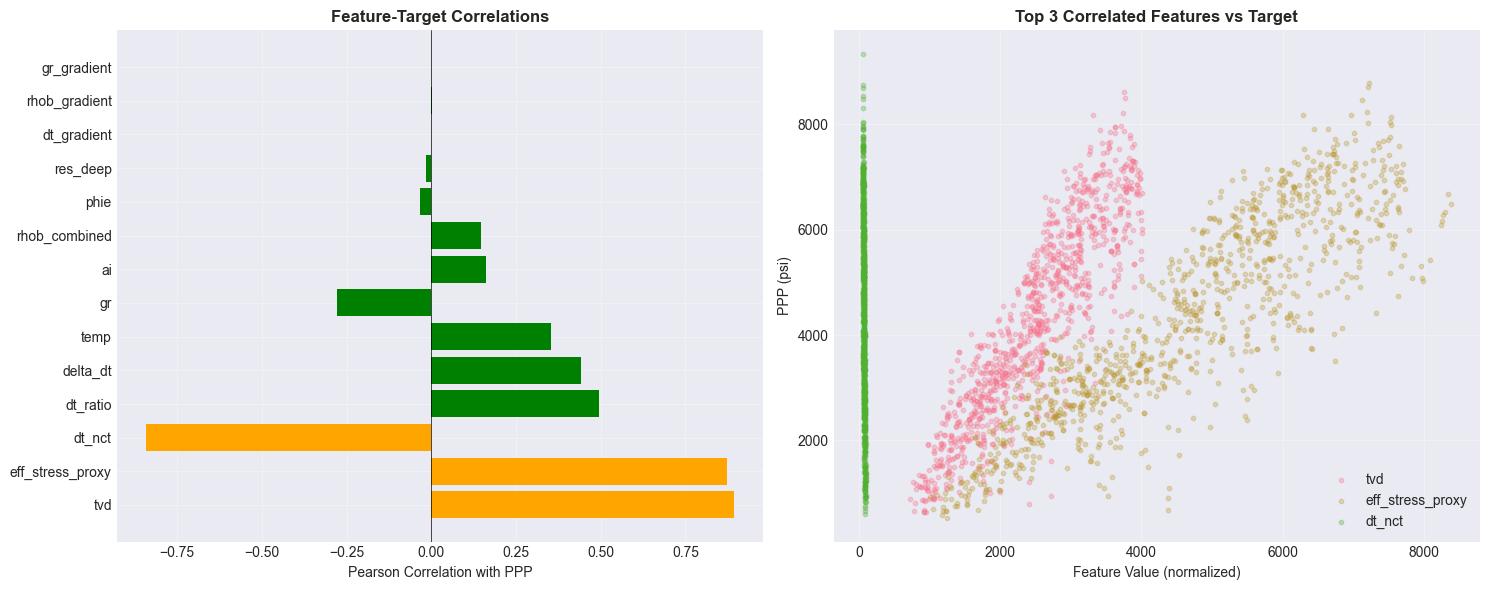

In [13]:
correlation_results = analyze_feature_target_correlation(
    df_train, selected_features
)
results['correlations'] = correlation_results

## 4. FEATURE IMPORTANCE BASELINE (RANDOM FOREST)

In [5]:
def analyze_feature_importance(df, features, target='ppp', n_estimators=100):
    """
    Quick Random Forest to assess feature importance
    
    INTERPRETATION:
    - Importance < 0.01: Consider dropping
    - Cumulative importance helps identify minimal feature set
    """
    print("\n" + "="*80)
    print("FEATURE IMPORTANCE ANALYSIS - Random Forest Baseline")
    print("="*80)
    
    # Prepare data
    valid_features = [f for f in features if f in df.columns]
    X = df[valid_features].dropna()
    y = df.loc[X.index, target]
    
    # Train Random Forest
    print(f"Training Random Forest with {n_estimators} trees...")
    rf = RandomForestRegressor(n_estimators=n_estimators, max_depth=15, 
                               random_state=42, n_jobs=-1)
    rf.fit(X, y)
    
    # Get importance scores
    importance_df = pd.DataFrame({
        'Feature': valid_features,
        'Importance': rf.feature_importances_
    }).sort_values('Importance', ascending=False)
    
    # Add cumulative importance
    importance_df['Cumulative_Importance'] = importance_df['Importance'].cumsum()
    
    print("\nFeature Importance Ranking:")
    print("-"*80)
    for _, row in importance_df.iterrows():
        bar_length = int(row['Importance'] * 200)
        bar = '█' * bar_length
        print(f"{row['Feature']:20}: {row['Importance']:.4f} {bar}")
    
    # Visualize
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # Importance bar plot
    ax = axes[0]
    ax.barh(range(len(importance_df)), importance_df['Importance'])
    ax.set_yticks(range(len(importance_df)))
    ax.set_yticklabels(importance_df['Feature'])
    ax.set_xlabel('Importance')
    ax.set_title('Feature Importance (Random Forest)', fontweight='bold')
    ax.grid(True, alpha=0.3)
    
    # Cumulative importance
    ax = axes[1]
    ax.plot(range(len(importance_df)), importance_df['Cumulative_Importance'], 
            marker='o', linewidth=2, markersize=6)
    ax.axhline(y=0.95, color='r', linestyle='--', label='95% variance')
    ax.set_xlabel('Number of Features')
    ax.set_ylabel('Cumulative Importance')
    ax.set_title('Cumulative Feature Importance', fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Identify features to potentially drop
    low_importance = importance_df[importance_df['Importance'] < 0.01]['Feature'].tolist()
    n_features_95 = (importance_df['Cumulative_Importance'] < 0.95).sum() + 1
    
    print(f"\n{'='*40}")
    print(f"FEATURE SELECTION INSIGHTS:")
    print(f"  - Features with importance < 1%: {low_importance}")
    print(f"  - Features needed for 95% importance: {n_features_95}/{len(importance_df)}")
    
    # Quick model performance check
    from sklearn.metrics import r2_score, mean_squared_error
    y_pred = rf.predict(X)
    r2 = r2_score(y, y_pred)
    rmse = np.sqrt(mean_squared_error(y, y_pred))
    
    print(f"\nRandom Forest Training Performance:")
    print(f"  - R² Score: {r2:.4f}")
    print(f"  - RMSE: {rmse:.2f} psi")
    
    return importance_df, rf



FEATURE IMPORTANCE ANALYSIS - Random Forest Baseline
Training Random Forest with 100 trees...

Feature Importance Ranking:
--------------------------------------------------------------------------------
tvd                 : 0.6623 ████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████
dt_nct              : 0.1262 █████████████████████████
eff_stress_proxy    : 0.0793 ███████████████
dt_ratio            : 0.0774 ███████████████
temp                : 0.0237 ████
res_deep            : 0.0154 ███
delta_dt            : 0.0075 █
gr                  : 0.0034 
phie                : 0.0029 
ai                  : 0.0007 
rhob_combined       : 0.0003 
gr_gradient         : 0.0003 
dt_gradient         : 0.0002 
rhob_gradient       : 0.0002 


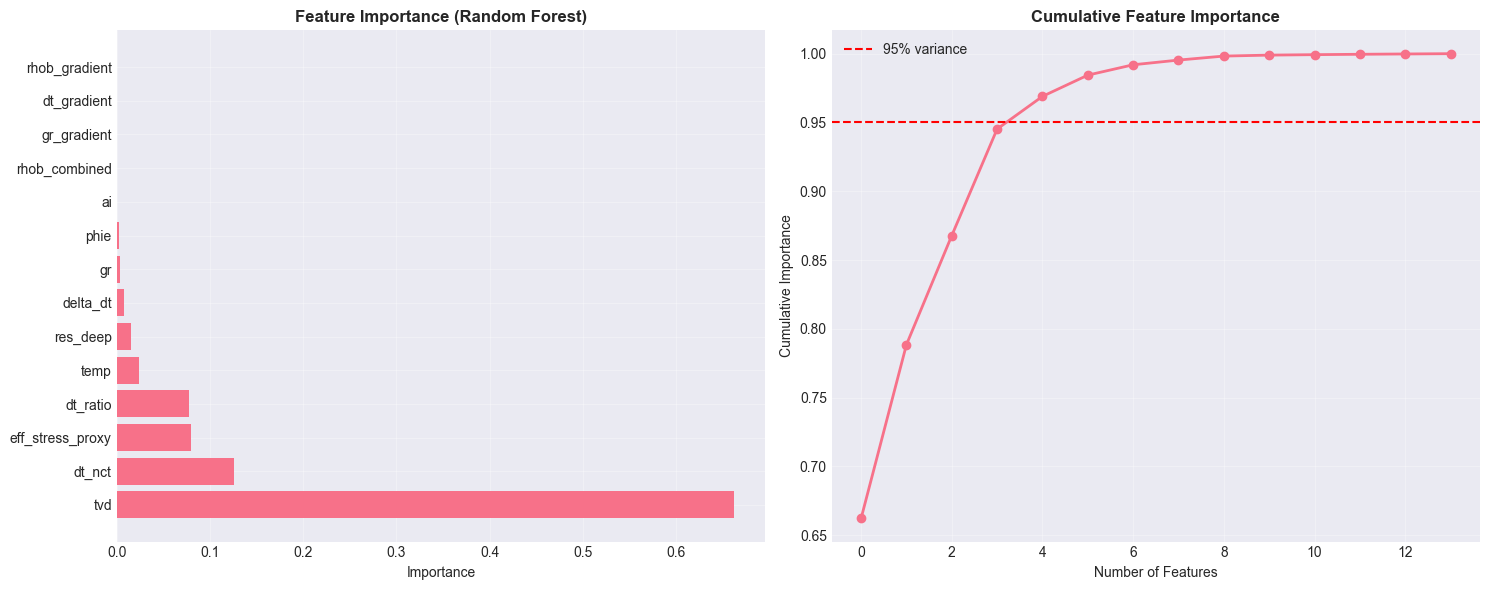


FEATURE SELECTION INSIGHTS:
  - Features with importance < 1%: ['delta_dt', 'gr', 'phie', 'ai', 'rhob_combined', 'gr_gradient', 'dt_gradient', 'rhob_gradient']
  - Features needed for 95% importance: 5/14

Random Forest Training Performance:
  - R² Score: 0.9959
  - RMSE: 118.30 psi


In [20]:
importance_results, rf_model = analyze_feature_importance(
    df_train, selected_features
)
results['importance'] = importance_results

## 5. PRESSURE REGIME ANALYSIS

In [6]:
def analyze_pressure_regimes(df_train, df_test, target='ppp'):
    """
    Analyze distribution of pressure regimes in train vs test
    
    INTERPRETATION:
    - Balanced distribution across regimes is ideal
    - Imbalanced regimes may need stratified sampling or weighting
    """
    print("\n" + "="*80)
    print("PRESSURE REGIME DISTRIBUTION ANALYSIS")
    print("="*80)
    
    def classify_pressure(df):
        """Classify pressure regimes based on overpressure ratio"""
        df = df.copy()
        df['pressure_ratio'] = df['ppp'] / df['hp']
        df['regime'] = pd.cut(df['pressure_ratio'], 
                              bins=[0, 1.1, 1.3, 1.5, np.inf],
                              labels=['Normal', 'Mild OP', 'Moderate OP', 'Severe OP'])
        return df
    
    # Classify regimes
    df_train = classify_pressure(df_train)
    df_test = classify_pressure(df_test) if df_test is not None else None
    
    # Calculate distributions
    train_dist = df_train['regime'].value_counts(normalize=True).sort_index()
    
    print("\nTraining Set Pressure Regimes:")
    for regime, pct in train_dist.items():
        count = (df_train['regime'] == regime).sum()
        print(f"  {regime:15}: {pct*100:5.1f}% ({count:,} samples)")
    
    if df_test is not None:
        test_dist = df_test['regime'].value_counts(normalize=True).sort_index()
        print("\nTest Set Pressure Regimes:")
        for regime, pct in test_dist.items():
            count = (df_test['regime'] == regime).sum()
            print(f"  {regime:15}: {pct*100:5.1f}% ({count:,} samples)")
        
        # Compare distributions
        print("\nRegime Distribution Shift:")
        for regime in train_dist.index:
            if regime in test_dist.index:
                shift = (test_dist[regime] - train_dist[regime]) * 100
                print(f"  {regime:15}: {shift:+6.1f}% shift")
    
    # Visualize
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Training distribution
    ax = axes[0]
    train_dist.plot(kind='bar', ax=ax, color='steelblue')
    ax.set_title('Training Set Pressure Regimes', fontweight='bold')
    ax.set_ylabel('Proportion')
    ax.set_xlabel('Pressure Regime')
    ax.grid(True, alpha=0.3)
    
    # Test distribution
    if df_test is not None:
        ax = axes[1]
        test_dist.plot(kind='bar', ax=ax, color='coral')
        ax.set_title('Test Set Pressure Regimes', fontweight='bold')
        ax.set_ylabel('Proportion')
        ax.set_xlabel('Pressure Regime')
        ax.grid(True, alpha=0.3)
    
    # Pressure ratio distributions
    ax = axes[2]
    ax.hist(df_train['pressure_ratio'], bins=50, alpha=0.6, 
            label='Train', density=True, color='steelblue')
    if df_test is not None:
        ax.hist(df_test['pressure_ratio'], bins=50, alpha=0.6, 
                label='Test', density=True, color='coral')
    ax.set_xlabel('Pressure Ratio (PPP/HP)')
    ax.set_ylabel('Density')
    ax.set_title('Pressure Ratio Distribution', fontweight='bold')
    ax.axvline(x=1.0, color='green', linestyle='--', label='Hydrostatic')
    ax.axvline(x=1.3, color='orange', linestyle='--', label='Moderate OP')
    ax.axvline(x=1.5, color='red', linestyle='--', label='Severe OP')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return df_train, df_test



PRESSURE REGIME DISTRIBUTION ANALYSIS

Training Set Pressure Regimes:
  Normal         :  33.2% (74,484 samples)
  Mild OP        :  31.7% (71,069 samples)
  Moderate OP    :  23.8% (53,512 samples)
  Severe OP      :  11.3% (25,481 samples)

Test Set Pressure Regimes:
  Normal         :  43.7% (19,832 samples)
  Mild OP        :  30.3% (13,745 samples)
  Moderate OP    :  20.0% (9,054 samples)
  Severe OP      :   6.0% (2,728 samples)

Regime Distribution Shift:
  Normal         :  +10.6% shift
  Mild OP        :   -1.3% shift
  Moderate OP    :   -3.9% shift
  Severe OP      :   -5.3% shift


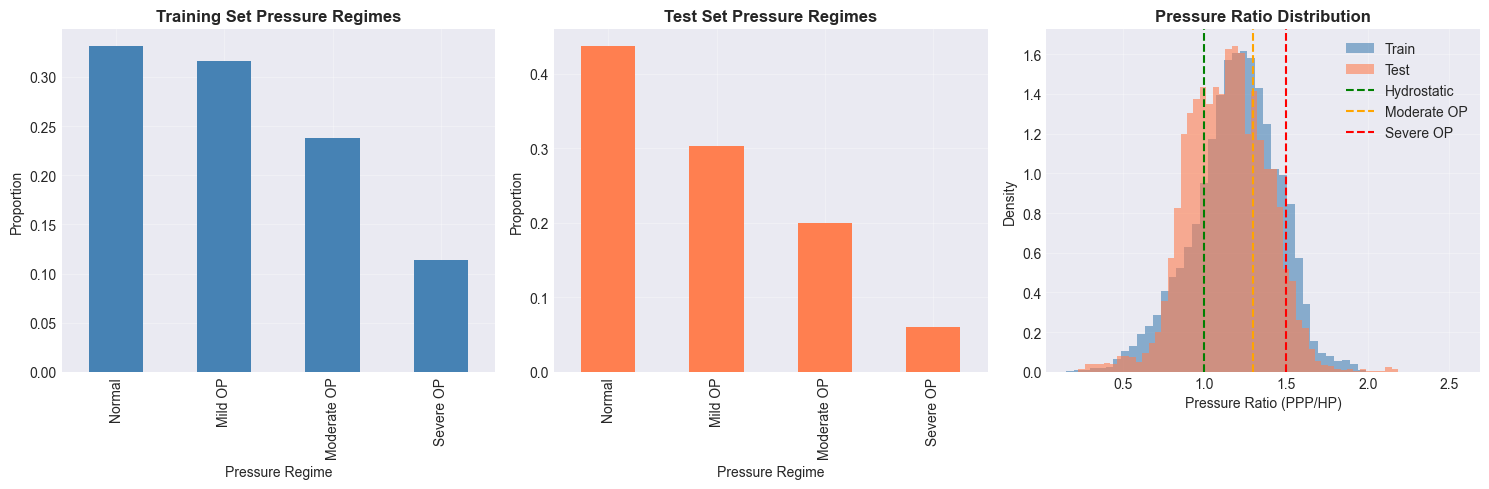

In [19]:
df_train_regime, df_test_regime = analyze_pressure_regimes(
    df_train, df_test
)

## 6. PHYSICAL CONSISTENCY CHECKS

In [7]:
def check_physical_consistency(df):
    """
    Validate physical relationships in the data
    
    CRITICAL CHECKS:
    - OB > HP (always)
    - PPP between HP and OB
    - Porosity 0-1
    - Density increases with depth (generally)
    """
    print("\n" + "="*80)
    print("PHYSICAL CONSISTENCY VALIDATION")
    print("="*80)
    
    issues = []
    
    # Check 1: OB > HP
    violation_1 = (df['ob'] <= df['hp']).sum()
    if violation_1 > 0:
        issues.append(f"OB <= HP in {violation_1} samples")
    
    # Check 2: HP <= PPP <= OB
    violation_2a = (df['ppp'] < df['hp']).sum()
    violation_2b = (df['ppp'] > df['ob']).sum()
    if violation_2a > 0:
        issues.append(f"PPP < HP in {violation_2a} samples")
    if violation_2b > 0:
        issues.append(f"PPP > OB in {violation_2b} samples")
    
    # Check 3: Porosity bounds
    if 'phie' in df.columns:
        violation_3a = (df['phie'] < 0).sum()
        violation_3b = (df['phie'] > 1).sum()
        if violation_3a > 0:
            issues.append(f"Negative porosity in {violation_3a} samples")
        if violation_3b > 0:
            issues.append(f"Porosity > 1 in {violation_3b} samples")
    
    # Check 4: Density positive
    violation_4 = (df['rhob_combined'] <= 0).sum()
    if violation_4 > 0:
        issues.append(f"Non-positive density in {violation_4} samples")
    
    # Report results
    if issues:
        print("🔴 PHYSICAL VIOLATIONS DETECTED:")
        for issue in issues:
            print(f"   - {issue}")
    else:
        print("✅ All physical consistency checks passed!")
    
    # Pressure relationships plot
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # Pressure vs depth
    ax = axes[0]
    sample = df.sample(min(5000, len(df)))
    ax.scatter(sample['hp'], sample['tvd'], alpha=0.3, s=5, label='HP')
    ax.scatter(sample['ppp'], sample['tvd'], alpha=0.3, s=5, label='PPP')
    ax.scatter(sample['ob'], sample['tvd'], alpha=0.3, s=5, label='OB')
    ax.set_xlabel('Pressure (psi)')
    ax.set_ylabel('TVD (m)')
    ax.set_title('Pressure Profiles', fontweight='bold')
    ax.invert_yaxis()
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Effective stress
    ax = axes[1]
    eff_stress_actual = sample['ob'] - sample['ppp']
    eff_stress_hydro = sample['ob'] - sample['hp']
    ax.scatter(eff_stress_hydro, eff_stress_actual, alpha=0.3, s=5)
    ax.plot([0, eff_stress_hydro.max()], [0, eff_stress_hydro.max()], 
            'r--', label='Hydrostatic line')
    ax.set_xlabel('Effective Stress (Hydrostatic) (psi)')
    ax.set_ylabel('Effective Stress (Actual) (psi)')
    ax.set_title('Effective Stress Comparison', fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return issues



PHYSICAL CONSISTENCY VALIDATION
🔴 PHYSICAL VIOLATIONS DETECTED:
   - PPP < HP in 47399 samples
   - PPP > OB in 9 samples


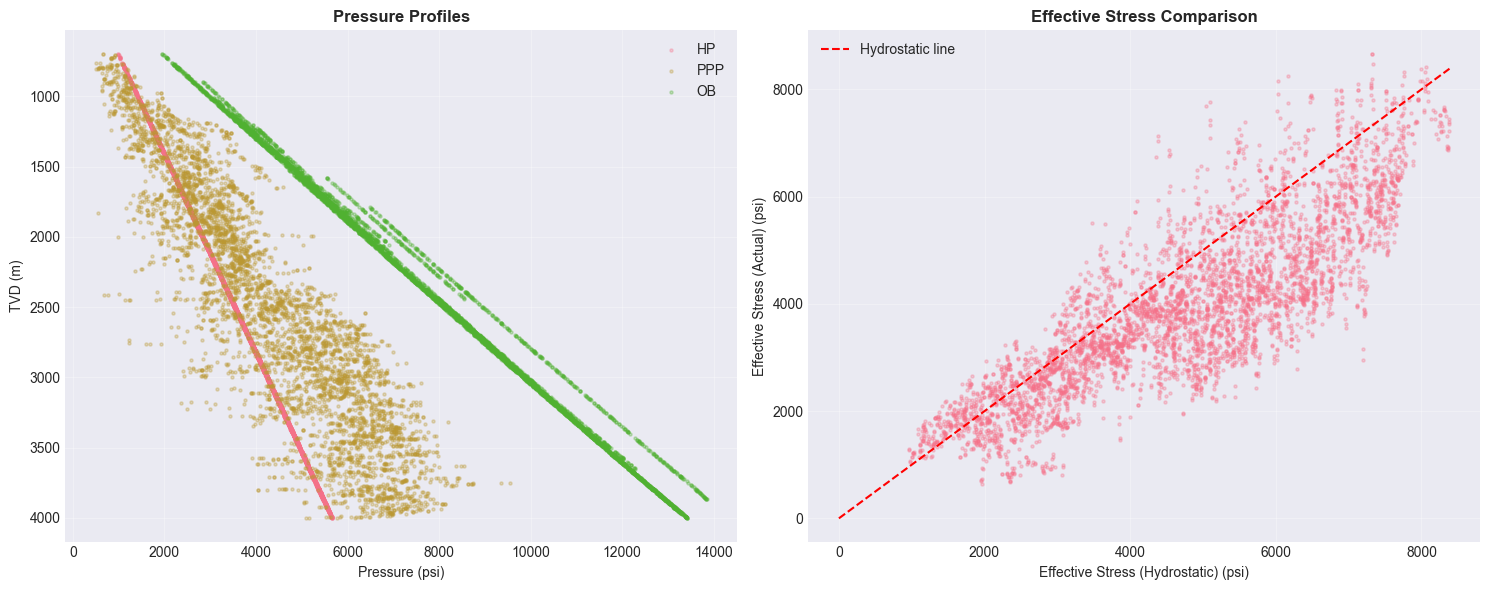

In [18]:
consistency_issues = check_physical_consistency(df_train)
results['physical_issues'] = consistency_issues

In [ ]:
KEEP = ['tvd', 'dt', 'dt_nct', 'rhob_combined', 'gr', 'res_deep', 'phie', 'hp', 'ob']
ADD = ['eaton_ratio', 'log_dt_ratio', 'velocity', 'hp_gradient', 'ob_gradient']
DROP = ['eff_stress_proxy', 'delta_dt']  # These cause collinearity

FINAL_FEATURES = [
    # Depth
    'tvd',                    # Keep but normalize per well
    
    # Primary pressure indicators
    'eaton_ratio',            # (dt/dt_nct)^3 - Works for all conditions
    'dt_ratio',               # dt/dt_nct - Linear version
    
    # Pressure gradients (normalized)
    'hp_gradient',            # Removes depth bias
    'ob_gradient',            # Overburden gradient
    
    # Rock properties  
    'gr',                     # Lithology indicator
    'rhob_combined',          # Bulk density
    'phie',                   # Effective porosity (impute from density if missing)
    
    # Fluid/pressure indicators
    'res_deep',               # Resistivity - fluid type
    'temp',                   # Temperature gradient
    
    # Well-normalized depth (new)
    'tvd_normalized'          # tvd / max_tvd_per_well
]

# Target
TARGET = 'pressure_ratio'  # PPP/HP - Perfect for full spectrum

# Don't need these (redundant/collinear):
DROP = ['hp', 'ob', 'dt', 'dphi', 'phit', 'sphi', 'eff_stress_proxy', 
        'all_gradient_features']


---

# New Validation checks post updates in preprocessing pipeline

In [2]:
import pandas as pd
import numpy as np

# Load the processed data
train = pd.read_csv('train_data.csv')
val = pd.read_csv('val_data.csv') 
test = pd.read_csv('test_data.csv')

print("="*60)
print("DATA VALIDATION CHECKS")
print("="*60)

# 1. Check pressure ratio ranges (should include < 1.0)
print("\n1. PRESSURE RATIO RANGES:")
for name, df in [('Train', train), ('Val', val), ('Test', test)]:
    pr = df['pressure_ratio']
    print(f"{name}: min={pr.min():.3f}, max={pr.max():.3f}, mean={pr.mean():.3f}")
    print(f"  Underpressured (< 0.9): {(pr < 0.9).mean()*100:.1f}%")
    print(f"  Normal (0.9-1.05): {((pr >= 0.9) & (pr <= 1.05)).mean()*100:.1f}%")
    print(f"  Overpressured (> 1.05): {(pr > 1.05).mean()*100:.1f}%")

# 2. Check for remaining NaNs in critical features
print("\n2. MISSING VALUES CHECK:")
critical_features = ['tvd', 'eaton_ratio', 'dt_ratio', 'gr', 'rhob_combined', 'phie']
for df_name, df in [('Train', train), ('Val', val), ('Test', test)]:
    missing = df[critical_features].isna().sum().sum()
    print(f"{df_name}: {missing} missing values in critical features")

# 3. Verify Eaton ratio calculation
print("\n3. EATON RATIO VALIDATION:")
for df_name, df in [('Train', train), ('Val', val), ('Test', test)]:
    # Recalculate to verify
    eaton_check = (df['dt'] / df['dt_nct']) ** 3
    diff = np.abs(df['eaton_ratio'] - eaton_check).max()
    print(f"{df_name}: Max difference = {diff:.6f} (should be ~0)")

# 4. Check feature correlations with target
print("\n4. TOP FEATURE CORRELATIONS WITH PRESSURE_RATIO:")
correlations = train[critical_features + ['pressure_ratio']].corr()['pressure_ratio'].sort_values(ascending=False)
print(correlations.head(10))

# 5. Verify no data leakage between splits
print("\n5. WELL SEPARATION CHECK:")
train_wells = set(train['well_id'].unique())
val_wells = set(val['well_id'].unique())
test_wells = set(test['well_id'].unique())

overlap_train_val = train_wells & val_wells
overlap_train_test = train_wells & test_wells
overlap_val_test = val_wells & test_wells

print(f"Train-Val overlap: {overlap_train_val if overlap_train_val else 'None ✓'}")
print(f"Train-Test overlap: {overlap_train_test if overlap_train_test else 'None ✓'}")
print(f"Val-Test overlap: {overlap_val_test if overlap_val_test else 'None ✓'}")

# 6. Check pressure regime balance
print("\n6. PRESSURE REGIME DISTRIBUTION:")
for name, df in [('Train', train), ('Val', val), ('Test', test)]:
    regime_counts = df['pressure_regime'].value_counts(normalize=True).sort_index()
    print(f"\n{name}:")
    for regime, pct in regime_counts.items():
        print(f"  {regime:15}: {pct*100:5.1f}%")

DATA VALIDATION CHECKS

1. PRESSURE RATIO RANGES:
Train: min=0.067, max=2.187, mean=1.229
  Underpressured (< 0.9): 8.1%
  Normal (0.9-1.05): 12.3%
  Overpressured (> 1.05): 79.5%
Val: min=0.107, max=2.566, mean=0.995
  Underpressured (< 0.9): 37.7%
  Normal (0.9-1.05): 18.0%
  Overpressured (> 1.05): 44.3%
Test: min=0.299, max=1.768, mean=0.939
  Underpressured (< 0.9): 43.2%
  Normal (0.9-1.05): 26.3%
  Overpressured (> 1.05): 30.4%

2. MISSING VALUES CHECK:
Train: 0 missing values in critical features
Val: 0 missing values in critical features
Test: 0 missing values in critical features

3. EATON RATIO VALIDATION:
Train: Max difference = 0.000000 (should be ~0)
Val: Max difference = 0.000000 (should be ~0)
Test: Max difference = 0.000000 (should be ~0)

4. TOP FEATURE CORRELATIONS WITH PRESSURE_RATIO:
pressure_ratio    1.000000
dt_ratio          0.706530
eaton_ratio       0.622484
phie              0.493475
tvd               0.211499
gr               -0.060813
rhob_combined    -0.44

## Running quick baseline test with RF

In [3]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error

# Get features from metadata
import json
with open('preprocessing_metadata.json', 'r') as f:
    metadata = json.load(f)
features = metadata['predictor_features']

# Quick baseline
X_train = train[features]
y_train = train['pressure_ratio']
X_val = val[features]
y_val = val['pressure_ratio']

rf = RandomForestRegressor(n_estimators=100, max_depth=15, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_val)

print(f"Validation R² (pressure_ratio): {r2_score(y_val, y_pred):.4f}")

# Convert back to absolute pressure
y_pred_psi = y_pred * val['hp']
y_true_psi = val['ppp']
print(f"RMSE (psi): {np.sqrt(mean_squared_error(y_true_psi, y_pred_psi)):.2f}")

Validation R² (pressure_ratio): -0.1793
RMSE (psi): 844.54


---

# cross-checking on exact reason for bad results on baseline

### Possible reason: imbalanced split

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load data
train = pd.read_csv('train_data.csv')
val = pd.read_csv('val_data.csv')
test = pd.read_csv('test_data.csv')

In [8]:
# Analyze pressure distribution BY WELL
def analyze_well_pressure_distributions():
    """Understand pressure characteristics of each well"""
    
    all_data = pd.concat([
        train.assign(split='train'),
        val.assign(split='val'),
        test.assign(split='test')
    ])
    
    well_stats = []
    for well in all_data['well_id'].unique():
        well_data = all_data[all_data['well_id'] == well]
        
        stats = {
            'well': well,
            'split': well_data['split'].iloc[0],
            'samples': len(well_data),
            'mean_pressure_ratio': well_data['pressure_ratio'].mean(),
            'median_pressure_ratio': well_data['pressure_ratio'].median(),
            'pct_underpressured': (well_data['pressure_ratio'] < 0.9).mean() * 100,
            'pct_normal': ((well_data['pressure_ratio'] >= 0.9) & 
                          (well_data['pressure_ratio'] <= 1.05)).mean() * 100,
            'pct_overpressured': (well_data['pressure_ratio'] > 1.05).mean() * 100,
            'mean_depth': well_data['tvd'].mean()
        }
        well_stats.append(stats)
    
    well_df = pd.DataFrame(well_stats).sort_values('mean_pressure_ratio')
    
    print("="*80)
    print("WELL-BY-WELL PRESSURE CHARACTERISTICS")
    print("="*80)
    
    for split in ['train', 'val', 'test']:
        print(f"\n{split.upper()} WELLS:")
        split_wells = well_df[well_df['split'] == split]
        for _, row in split_wells.iterrows():
            print(f"{row['well']:25} PR={row['mean_pressure_ratio']:.3f} "
                  f"(Under:{row['pct_underpressured']:5.1f}% "
                  f"Normal:{row['pct_normal']:5.1f}% "
                  f"Over:{row['pct_overpressured']:5.1f}%)")
    
    # Visualize
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # Plot 1: Mean pressure ratio by well
    ax = axes[0]
    colors = {'train': 'blue', 'val': 'orange', 'test': 'red'}
    for split in ['train', 'val', 'test']:
        split_data = well_df[well_df['split'] == split]
        ax.bar(range(len(split_data)), split_data['mean_pressure_ratio'], 
               label=split, color=colors[split], alpha=0.7)
    ax.axhline(y=1.0, color='green', linestyle='--', label='Hydrostatic')
    ax.set_ylabel('Mean Pressure Ratio')
    ax.set_title('Pressure Characteristics by Well')
    ax.legend()
    
    # Plot 2: Distribution overlap
    ax = axes[1]
    train['pressure_ratio'].hist(bins=50, alpha=0.5, label='Train', 
                                 density=True, ax=ax, color='blue')
    val['pressure_ratio'].hist(bins=50, alpha=0.5, label='Val', 
                               density=True, ax=ax, color='orange')
    test['pressure_ratio'].hist(bins=50, alpha=0.5, label='Test', 
                                density=True, ax=ax, color='red')
    ax.axvline(x=1.0, color='green', linestyle='--', label='Hydrostatic')
    ax.set_xlabel('Pressure Ratio')
    ax.set_ylabel('Density')
    ax.set_title('Distribution Mismatch')
    ax.legend()
    
    plt.tight_layout()
    plt.show()
    
    return well_df

WELL-BY-WELL PRESSURE CHARACTERISTICS

TRAIN WELLS:
KAL-01                    PR=1.038 (Under: 24.2% Normal: 31.1% Over: 44.7%)
RAJIAN-01                 PR=1.072 (Under: 21.3% Normal: 21.9% Over: 56.8%)
SHAHAB 1A                 PR=1.073 (Under: 11.8% Normal: 29.0% Over: 59.2%)
AMIRPUR-01                PR=1.104 (Under:  1.4% Normal: 18.3% Over: 80.3%)
MISSA KESWAL-02           PR=1.120 (Under: 24.7% Normal: 12.3% Over: 63.1%)
Balkassar OXY 01          PR=1.121 (Under:  1.8% Normal: 23.7% Over: 74.5%)
TURKWAL DEEP X 2          PR=1.145 (Under: 11.6% Normal: 17.5% Over: 70.9%)
MINWAL-2                  PR=1.170 (Under:  8.3% Normal: 16.6% Over: 75.0%)
Balkassar OXY 02          PR=1.190 (Under:  0.0% Normal:  2.8% Over: 97.2%)
MISSA KESWAL-01           PR=1.224 (Under: 12.4% Normal: 17.8% Over: 69.9%)
BHANGALI-01               PR=1.284 (Under:  3.7% Normal:  9.5% Over: 86.8%)
PINDORI-3                 PR=1.298 (Under:  8.9% Normal:  7.6% Over: 83.5%)
PINDORI-2                 PR=1.332 (

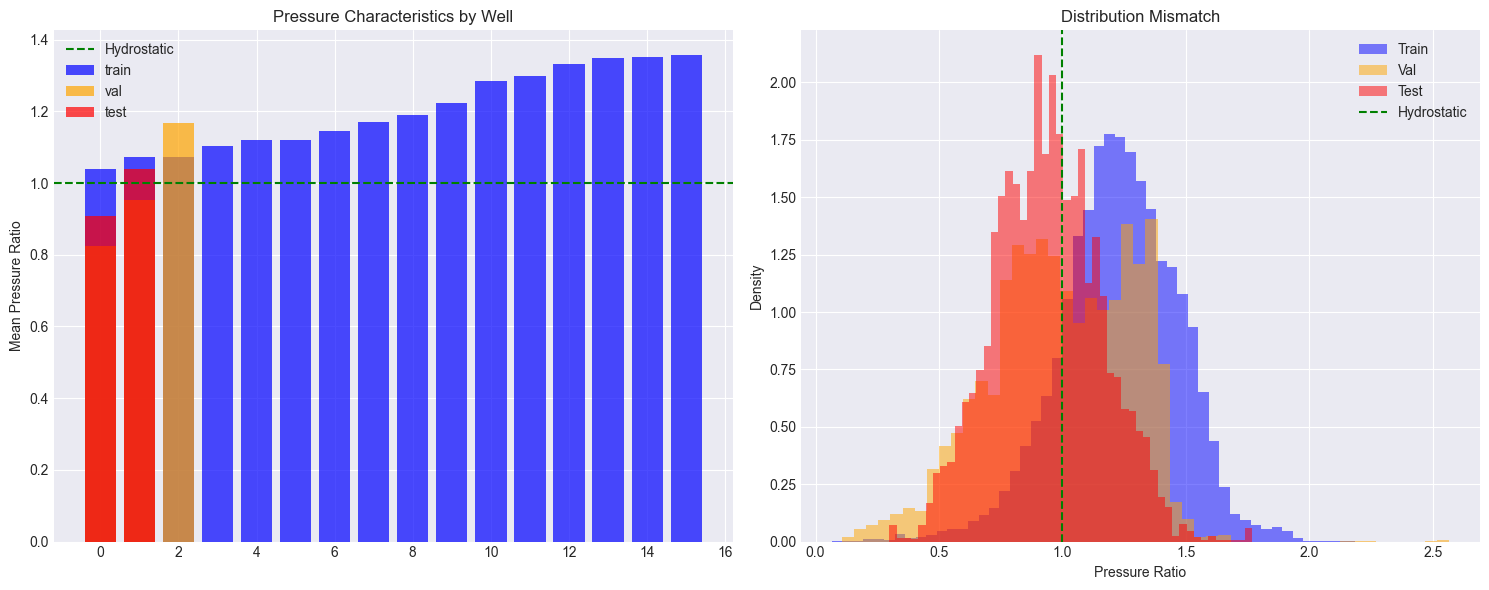

In [9]:
well_analysis = analyze_well_pressure_distributions()

In [10]:
# Check if specific features have different distributions
def check_feature_shifts():
    """Check which features have the most domain shift"""
    from scipy.stats import ks_2samp
    
    print("\n" + "="*80)
    print("FEATURE DISTRIBUTION SHIFTS (KS Test)")
    print("="*80)
    
    features = ['tvd', 'eaton_ratio', 'dt_ratio', 'gr', 'rhob_combined', 'phie']
    
    for feat in features:
        # Train vs Val
        ks_val, p_val = ks_2samp(train[feat].dropna(), val[feat].dropna())
        # Train vs Test  
        ks_test, p_test = ks_2samp(train[feat].dropna(), test[feat].dropna())
        
        print(f"{feat:15}: Train-Val KS={ks_val:.3f} (p={p_val:.3e}), "
              f"Train-Test KS={ks_test:.3f} (p={p_test:.3e})")

In [12]:
check_feature_shifts()


FEATURE DISTRIBUTION SHIFTS (KS Test)
tvd            : Train-Val KS=0.423 (p=0.000e+00), Train-Test KS=0.328 (p=0.000e+00)
eaton_ratio    : Train-Val KS=0.265 (p=0.000e+00), Train-Test KS=0.390 (p=0.000e+00)
dt_ratio       : Train-Val KS=0.265 (p=0.000e+00), Train-Test KS=0.390 (p=0.000e+00)
gr             : Train-Val KS=0.157 (p=0.000e+00), Train-Test KS=0.257 (p=0.000e+00)
rhob_combined  : Train-Val KS=0.254 (p=0.000e+00), Train-Test KS=0.237 (p=0.000e+00)
phie           : Train-Val KS=0.127 (p=3.609e-293), Train-Test KS=0.103 (p=8.954e-219)


## verifying if redistribution will work

In [ ]:
# Define new well assignments
NEW_TRAIN_WELLS = [
    'JOYAMAIR-4', 'TURKWAL DEEP 01',  # Underpressured
    'KAL-01', 'RAJIAN-01', 'SHAHAB 1A', 'AMIRPUR-01',  # Balanced
    'PINDORI-1', 'BHANGALI-01', 'QAZIAN -1X', 'Balkassar OXY 02', 
    'MISSA KESWAL-01', 'MISSA KESWAL-03', 'PINDORI-3'  # Overpressured
]

NEW_VAL_WELLS = [
    'MINWAL-X-1', 'MINWAL-2', 'MISSA KESWAL-02', 'Balkassar OXY 01'
]

NEW_TEST_WELLS = [
    'RAJIAN-03A', 'PINDORI-2', 'TURKWAL DEEP X 2', 'Balkassar POL 01'
]

# Load current data to check distribution
current_data = pd.concat([
    pd.read_csv('train_data.csv'),
    pd.read_csv('val_data.csv'),
    pd.read_csv('test_data.csv')
])

# Function to check distribution with new splits
def check_new_distribution(data, train_wells, val_wells, test_wells):
    """Verify the new distribution will be balanced"""
    
    print("="*70)
    print("PREDICTED DISTRIBUTION WITH NEW SPLITS")
    print("="*70)
    
    for split_name, well_list in [('TRAIN', train_wells), 
                                   ('VALIDATION', val_wells), 
                                   ('TEST', test_wells)]:
        split_data = data[data['well_id'].isin(well_list)]
        
        if len(split_data) == 0:
            print(f"\n{split_name}: No data found - check well names!")
            continue
            
        pr = split_data['pressure_ratio']
        n_samples = len(split_data)
        
        print(f"\n{split_name} SET:")
        print(f"  Samples: {n_samples:,} ({n_samples/len(data)*100:.1f}% of total)")
        print(f"  Wells: {len(well_list)}")
        print(f"  Pressure Distribution:")
        print(f"    Underpressured (<0.9): {(pr < 0.9).mean()*100:5.1f}%")
        print(f"    Normal (0.9-1.05):     {((pr >= 0.9) & (pr <= 1.05)).mean()*100:5.1f}%")
        print(f"    Overpressured (>1.05): {(pr > 1.05).mean()*100:5.1f}%")
        print(f"  Mean pressure ratio: {pr.mean():.3f}")
        print(f"  Std pressure ratio:  {pr.std():.3f}")

# Check the new distribution
check_new_distribution(current_data, NEW_TRAIN_WELLS, NEW_VAL_WELLS, NEW_TEST_WELLS)

PREDICTED DISTRIBUTION WITH NEW SPLITS

TRAIN SET:
  Samples: 159,017 (58.3% of total)
  Wells: 13
  Pressure Distribution:
    Underpressured (<0.9):  13.3%
    Normal (0.9-1.05):      14.2%
    Overpressured (>1.05):  72.5%
  Mean pressure ratio: 1.192
  Std pressure ratio:  0.267

VALIDATION SET:
  Samples: 28,600 (10.5% of total)
  Wells: 4
  Pressure Distribution:
    Underpressured (<0.9):  11.5%
    Normal (0.9-1.05):      16.3%
    Overpressured (>1.05):  72.1%
  Mean pressure ratio: 1.148
  Std pressure ratio:  0.247

TEST SET:
  Samples: 84,929 (31.2% of total)
  Wells: 4
  Pressure Distribution:
    Underpressured (<0.9):  16.2%
    Normal (0.9-1.05):      13.4%
    Overpressured (>1.05):  70.4%
  Mean pressure ratio: 1.173
  Std pressure ratio:  0.254


### Updated preprocessing script: following above balanced split

#### Final baseline test

In [2]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import xgboost as xgb
import json

In [ ]:
# Load the reprocessed data
train = pd.read_csv('train_data.csv')
val = pd.read_csv('val_data.csv')
test = pd.read_csv('test_data.csv')

# Get features from metadata
with open('preprocessing_metadata.json', 'r') as f:
    metadata = json.load(f)
features = metadata['predictor_features']

# Prepare data
X_train = train[features]
y_train = train['pressure_ratio']
X_val = val[features]
y_val = val['pressure_ratio']

print("="*70)
print("BASELINE RANDOM FOREST TEST - BALANCED SPLITS")
print("="*70)

# Train baseline model
print("\nTraining Random Forest (n_estimators=200, max_depth=15)...")
rf = RandomForestRegressor(n_estimators=200, max_depth=15, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)

# Predictions on validation
y_pred_val = rf.predict(X_val)

# Metrics on pressure_ratio
r2_ratio = r2_score(y_val, y_pred_val)
rmse_ratio = np.sqrt(mean_squared_error(y_val, y_pred_val))
mae_ratio = mean_absolute_error(y_val, y_pred_val)

print("\n" + "="*40)
print("VALIDATION PERFORMANCE (Pressure Ratio)")
print("="*40)
print(f"R² Score:    {r2_ratio:.4f}")  # Should be positive now!
print(f"RMSE:        {rmse_ratio:.4f}")
print(f"MAE:         {mae_ratio:.4f}")

# Convert back to absolute pressure for practical evaluation
y_pred_psi = y_pred_val * val['hp']
y_true_psi = val['ppp']
rmse_psi = np.sqrt(mean_squared_error(y_true_psi, y_pred_psi))
mae_psi = mean_absolute_error(y_true_psi, y_pred_psi)
r2_psi = r2_score(y_true_psi, y_pred_psi)

print("\n" + "="*40)
print("VALIDATION PERFORMANCE (Absolute PPP in psi)")
print("="*40)
print(f"R² Score:    {r2_psi:.4f}")
print(f"RMSE:        {rmse_psi:.2f} psi")
print(f"MAE:         {mae_psi:.2f} psi")

# Feature importance
print("\n" + "="*40)
print("TOP 10 FEATURE IMPORTANCE")
print("="*40)
importance_df = pd.DataFrame({
    'feature': features,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)

for idx, row in importance_df.head(10).iterrows():
    print(f"{row['feature']:20}: {row['importance']:.4f}")

# Check performance by pressure regime
print("\n" + "="*40)
print("PERFORMANCE BY PRESSURE REGIME")
print("="*40)
val_with_pred = val.copy()
val_with_pred['pred_ratio'] = y_pred_val
val_with_pred['error'] = np.abs(val_with_pred['pressure_ratio'] - val_with_pred['pred_ratio'])

for regime in ['Underpressured', 'Normal', 'Mild_OP', 'Moderate_OP', 'Severe_OP']:
    regime_data = val_with_pred[val_with_pred['pressure_regime'] == regime]
    if len(regime_data) > 0:
        regime_r2 = r2_score(regime_data['pressure_ratio'], regime_data['pred_ratio'])
        regime_mae = regime_data['error'].mean()
        print(f"{regime:15}: R²={regime_r2:.3f}, MAE={regime_mae:.3f} ({len(regime_data):,} samples)")

BASELINE RANDOM FOREST TEST - BALANCED SPLITS

Training Random Forest (n_estimators=200, max_depth=15)...

VALIDATION PERFORMANCE (Pressure Ratio)
R² Score:    -0.0381
RMSE:        0.2521
MAE:         0.1958

VALIDATION PERFORMANCE (Absolute PPP in psi)
R² Score:    0.4852
RMSE:        542.19 psi
MAE:         425.27 psi

TOP 10 FEATURE IMPORTANCE
eaton_ratio         : 0.3243
dt_ratio            : 0.2538
hp_gradient         : 0.1520
ob_gradient         : 0.0816
temp                : 0.0452
tvd_normalized      : 0.0366
tvd                 : 0.0299
res_deep            : 0.0261
gr                  : 0.0204
phie                : 0.0198

PERFORMANCE BY PRESSURE REGIME
Underpressured : R²=-2.664, MAE=0.331 (3,302 samples)
Normal         : R²=-6.164, MAE=0.091 (4,671 samples)
Mild_OP        : R²=-4.115, MAE=0.074 (7,647 samples)
Moderate_OP    : R²=-13.017, MAE=0.252 (12,180 samples)
Severe_OP      : R²=-8.324, MAE=0.561 (800 samples)


---

Still bad; needs further investigation. 

Indication of fundamental problem. 

Alternatives:
- Diff target
- strarified sampling
- switch model

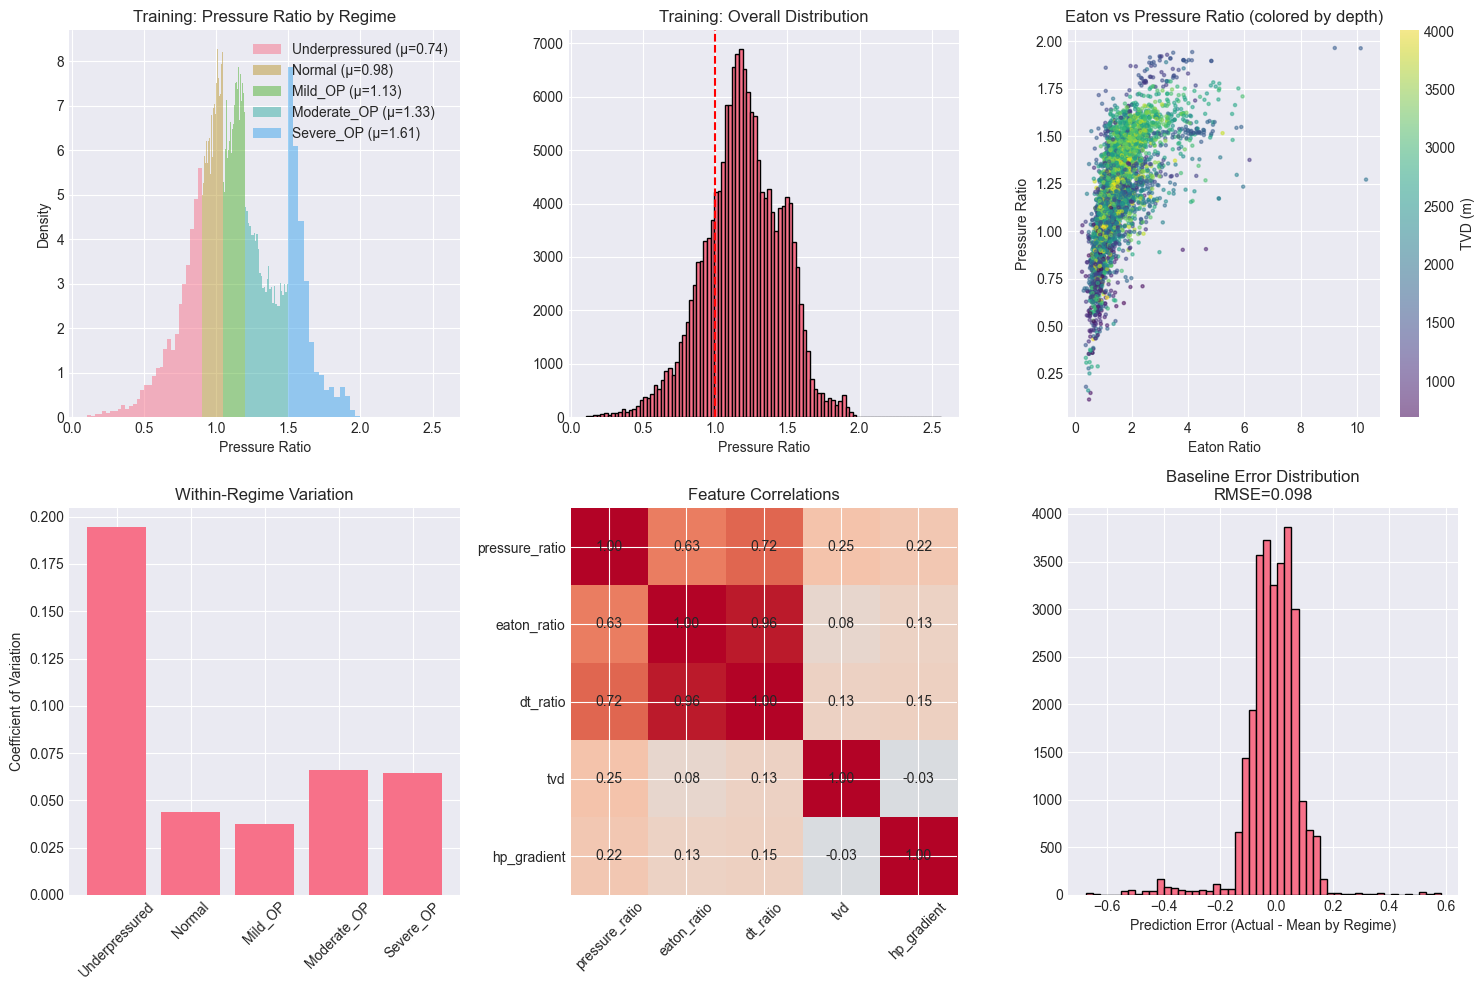

DIAGNOSTIC ANALYSIS

1. WITHIN-REGIME STATISTICS:
Underpressured : mean=0.743, std=0.145, CV=0.195
Normal         : mean=0.981, std=0.043, CV=0.044
Mild_OP        : mean=1.129, std=0.042, CV=0.038
Moderate_OP    : mean=1.335, std=0.088, CV=0.066
Severe_OP      : mean=1.605, std=0.103, CV=0.064

2. OVERLAP BETWEEN REGIMES:
Underpressured max: 0.900
Normal min: 0.900
Overlap exists: False

3. CORRELATION STRUCTURE:
Pressure_ratio correlations:
pressure_ratio    1.000000
dt_ratio          0.720130
eaton_ratio       0.630673
tvd               0.252708
hp_gradient       0.224927
ob_gradient       0.136992
tvd_normalized    0.091137
Name: pressure_ratio, dtype: float64

4. SIMPLE BASELINE COMPARISON:
R² of predicting mean by regime: 0.8418
Your RF R²: -0.0381
RF is worse than simple mean by regime


In [ ]:
# Load data
train = pd.read_csv('train_data.csv')
val = pd.read_csv('val_data.csv')

# Analyze what's happening with pressure_ratio
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Plot 1: Pressure ratio distribution by regime
ax = axes[0, 0]
for regime in ['Underpressured', 'Normal', 'Mild_OP', 'Moderate_OP', 'Severe_OP']:
    regime_data = train[train['pressure_regime'] == regime]['pressure_ratio']
    if len(regime_data) > 0:
        ax.hist(regime_data, alpha=0.5, label=f'{regime} (μ={regime_data.mean():.2f})', bins=30, density=True)
ax.set_xlabel('Pressure Ratio')
ax.set_ylabel('Density')
ax.set_title('Training: Pressure Ratio by Regime')
ax.legend()

# Plot 2: Check for multimodal distributions
ax = axes[0, 1]
train['pressure_ratio'].hist(bins=100, ax=ax, edgecolor='black')
ax.set_xlabel('Pressure Ratio')
ax.set_title('Training: Overall Distribution')
ax.axvline(x=1.0, color='red', linestyle='--', label='Hydrostatic')

# Plot 3: Eaton ratio vs pressure ratio
ax = axes[0, 2]
sample = train.sample(min(5000, len(train)))
scatter = ax.scatter(sample['eaton_ratio'], sample['pressure_ratio'], 
                    c=sample['tvd'], cmap='viridis', alpha=0.5, s=5)
ax.set_xlabel('Eaton Ratio')
ax.set_ylabel('Pressure Ratio')
ax.set_title('Eaton vs Pressure Ratio (colored by depth)')
plt.colorbar(scatter, ax=ax, label='TVD (m)')

# Plot 4: Variance analysis
ax = axes[1, 0]
regime_stats = []
for regime in ['Underpressured', 'Normal', 'Mild_OP', 'Moderate_OP', 'Severe_OP']:
    regime_data = train[train['pressure_regime'] == regime]['pressure_ratio']
    if len(regime_data) > 0:
        regime_stats.append({
            'regime': regime,
            'mean': regime_data.mean(),
            'std': regime_data.std(),
            'cv': regime_data.std() / regime_data.mean()  # Coefficient of variation
        })
regime_df = pd.DataFrame(regime_stats)
ax.bar(range(len(regime_df)), regime_df['cv'])
ax.set_xticks(range(len(regime_df)))
ax.set_xticklabels(regime_df['regime'], rotation=45)
ax.set_ylabel('Coefficient of Variation')
ax.set_title('Within-Regime Variation')

# Plot 5: Feature correlation heatmap
ax = axes[1, 1]
key_features = ['pressure_ratio', 'eaton_ratio', 'dt_ratio', 'tvd', 'hp_gradient']
corr = train[key_features].corr()
im = ax.imshow(corr, cmap='coolwarm', vmin=-1, vmax=1)
ax.set_xticks(range(len(key_features)))
ax.set_yticks(range(len(key_features)))
ax.set_xticklabels(key_features, rotation=45)
ax.set_yticklabels(key_features)
for i in range(len(key_features)):
    for j in range(len(key_features)):
        ax.text(j, i, f'{corr.iloc[i, j]:.2f}', ha='center', va='center')
ax.set_title('Feature Correlations')

# Plot 6: Residual analysis
ax = axes[1, 2]
# Simple baseline: predict mean by regime
val_baseline = val.copy()
for regime in val['pressure_regime'].unique():
    regime_mean = train[train['pressure_regime'] == regime]['pressure_ratio'].mean()
    val_baseline.loc[val_baseline['pressure_regime'] == regime, 'baseline_pred'] = regime_mean

val_baseline['baseline_error'] = val_baseline['pressure_ratio'] - val_baseline['baseline_pred']
ax.hist(val_baseline['baseline_error'], bins=50, edgecolor='black')
ax.set_xlabel('Prediction Error (Actual - Mean by Regime)')
ax.set_title(f'Baseline Error Distribution\nRMSE={val_baseline["baseline_error"].std():.3f}')

plt.tight_layout()
plt.show()

# Print diagnostics
print("="*70)
print("DIAGNOSTIC ANALYSIS")
print("="*70)

print("\n1. WITHIN-REGIME STATISTICS:")
for _, row in regime_df.iterrows():
    print(f"{row['regime']:15}: mean={row['mean']:.3f}, std={row['std']:.3f}, CV={row['cv']:.3f}")

print("\n2. OVERLAP BETWEEN REGIMES:")
# Check how much regimes overlap
under_data = train[train['pressure_regime'] == 'Underpressured']['pressure_ratio']
normal_data = train[train['pressure_regime'] == 'Normal']['pressure_ratio']
if len(under_data) > 0 and len(normal_data) > 0:
    overlap_pct = ((under_data.max() > normal_data.min()) & 
                   (normal_data.max() > under_data.min()))
    print(f"Underpressured max: {under_data.max():.3f}")
    print(f"Normal min: {normal_data.min():.3f}")
    print(f"Overlap exists: {overlap_pct}")

print("\n3. CORRELATION STRUCTURE:")
print("Pressure_ratio correlations:")
correlations = train[['pressure_ratio', 'eaton_ratio', 'dt_ratio', 'tvd', 'tvd_normalized', 
                     'hp_gradient', 'ob_gradient']].corr()['pressure_ratio'].sort_values(ascending=False)
print(correlations)

print("\n4. SIMPLE BASELINE COMPARISON:")
baseline_r2 = 1 - (val_baseline['baseline_error'].var() / val_baseline['pressure_ratio'].var())
print(f"R² of predicting mean by regime: {baseline_r2:.4f}")
print(f"Your RF R²: -0.0381")
print(f"RF is {'worse' if baseline_r2 > -0.0381 else 'better'} than simple mean by regime")

RF is learning patterns that actively hurt performance

The Random Forest is trying to learn continuous relationships across regime boundaries, but pressure_ratio is essentially a categorical variable with small perturbations.


**The RF is overfitting to noise and missing the regime structure**


In [ ]:
# Load data
train = pd.read_csv('train_data.csv')
val = pd.read_csv('val_data.csv')

with open('preprocessing_metadata.json', 'r') as f:
    metadata = json.load(f)
features = metadata['predictor_features']

print("="*70)
print("TWO-STAGE APPROACH: CLASSIFY THEN REGRESS")
print("="*70)

# STAGE 1: Classify pressure regime
print("\n--- STAGE 1: REGIME CLASSIFICATION ---")
X_train = train[features]
y_train_regime = train['pressure_regime']
X_val = val[features]
y_val_regime = val['pressure_regime']

# Train classifier
clf = RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42)
clf.fit(X_train, y_train_regime)
regime_pred = clf.predict(X_val)
regime_accuracy = accuracy_score(y_val_regime, regime_pred)
print(f"Regime classification accuracy: {regime_accuracy:.3f}")

# STAGE 2: Predict within regime (or use regime-specific models)
print("\n--- STAGE 2: WITHIN-REGIME PREDICTION ---")

# Approach 2A: Simple - Use mean of predicted regime
regime_means = train.groupby('pressure_regime')['pressure_ratio'].mean()
val_pred_simple = pd.Series(index=val.index)
for regime in regime_means.index:
    mask = pd.Series(regime_pred) == regime
    val_pred_simple[mask] = regime_means[regime]

r2_simple = r2_score(val['pressure_ratio'], val_pred_simple)
rmse_simple = np.sqrt(mean_squared_error(val['pressure_ratio'], val_pred_simple))
print(f"\nApproach A (Classify + Mean): R² = {r2_simple:.4f}, RMSE = {rmse_simple:.4f}")

# Approach 2B: Train regime-specific models
print("\n--- REGIME-SPECIFIC MODELS ---")
val_pred_specific = pd.Series(index=val.index, dtype=float)

for regime in train['pressure_regime'].unique():
    # Train on this regime
    train_regime = train[train['pressure_regime'] == regime]
    if len(train_regime) < 100:  # Skip if too few samples
        continue
        
    X_train_regime = train_regime[features]
    y_train_regime = train_regime['pressure_ratio']
    
    # Simpler model for within-regime (less depth to avoid overfitting)
    rf_regime = RandomForestRegressor(n_estimators=100, max_depth=8, random_state=42)
    rf_regime.fit(X_train_regime, y_train_regime)
    
    # Predict for validation samples in this regime
    val_mask = val['pressure_regime'] == regime
    if val_mask.sum() > 0:
        X_val_regime = val[val_mask][features]
        pred_regime = rf_regime.predict(X_val_regime)
        val_pred_specific[val_mask] = pred_regime
        
        # Regime performance
        actual_regime = val[val_mask]['pressure_ratio']
        r2_regime = r2_score(actual_regime, pred_regime)
        print(f"  {regime:15}: R² = {r2_regime:.3f} ({val_mask.sum():,} samples)")

r2_specific = r2_score(val['pressure_ratio'], val_pred_specific)
rmse_specific = np.sqrt(mean_squared_error(val['pressure_ratio'], val_pred_specific))
print(f"\nApproach B (Regime-Specific): R² = {r2_specific:.4f}, RMSE = {rmse_specific:.4f}")

# Approach 2C: Hybrid - Weighted combination
# Use regime means as baseline, add residual prediction
print("\n--- HYBRID APPROACH ---")
val_hybrid = val.copy()

# Add predicted regime
val_hybrid['pred_regime'] = regime_pred

# Add regime mean as baseline
for regime in regime_means.index:
    mask = val_hybrid['pred_regime'] == regime
    val_hybrid.loc[mask, 'baseline'] = regime_means[regime]

# Train residual model (predict deviation from regime mean)
train['regime_mean'] = train['pressure_regime'].map(regime_means)
train['residual'] = train['pressure_ratio'] - train['regime_mean']

# Only use most important features for residual
residual_features = ['eaton_ratio', 'dt_ratio', 'hp_gradient', 'ob_gradient']
rf_residual = RandomForestRegressor(n_estimators=100, max_depth=8, random_state=42)
rf_residual.fit(train[residual_features], train['residual'])

# Predict residuals
val_residuals = rf_residual.predict(val[residual_features])
val_hybrid['prediction'] = val_hybrid['baseline'] + val_residuals

r2_hybrid = r2_score(val['pressure_ratio'], val_hybrid['prediction'])
rmse_hybrid = np.sqrt(mean_squared_error(val['pressure_ratio'], val_hybrid['prediction']))
print(f"\nApproach C (Hybrid): R² = {r2_hybrid:.4f}, RMSE = {rmse_hybrid:.4f}")

# Compare all approaches
print("\n" + "="*70)
print("COMPARISON OF APPROACHES")
print("="*70)
print(f"Original RF (ignoring regimes):  R² = -0.0381")
print(f"Simple mean by regime:           R² = 0.8418")
print(f"Classify + Mean:                 R² = {r2_simple:.4f}")
print(f"Regime-Specific Models:          R² = {r2_specific:.4f}")
print(f"Hybrid (baseline + residual):    R² = {r2_hybrid:.4f}")

# Best approach for absolute pressure
best_pred = val_hybrid['prediction']  # or whichever performed best
val_psi_pred = best_pred * val['hp']
val_psi_actual = val['ppp']
r2_psi = r2_score(val_psi_actual, val_psi_pred)
rmse_psi = np.sqrt(mean_squared_error(val_psi_actual, val_psi_pred))
print(f"\nBest approach in absolute PPP: R² = {r2_psi:.4f}, RMSE = {rmse_psi:.2f} psi")

TWO-STAGE APPROACH: CLASSIFY THEN REGRESS

--- STAGE 1: REGIME CLASSIFICATION ---
Regime classification accuracy: 0.396

--- STAGE 2: WITHIN-REGIME PREDICTION ---

Approach A (Classify + Mean): R² = 0.0679, RMSE = 0.2389

--- REGIME-SPECIFIC MODELS ---
  Normal         : R² = -0.015 (4,671 samples)
  Mild_OP        : R² = -0.024 (7,647 samples)
  Underpressured : R² = -0.460 (3,302 samples)
  Moderate_OP    : R² = -0.649 (12,180 samples)
  Severe_OP      : R² = 0.203 (800 samples)

Approach B (Regime-Specific): R² = 0.8007, RMSE = 0.1105

--- HYBRID APPROACH ---

Approach C (Hybrid): R² = 0.0529, RMSE = 0.2408

COMPARISON OF APPROACHES
Original RF (ignoring regimes):  R² = -0.0381
Simple mean by regime:           R² = 0.8418
Classify + Mean:                 R² = 0.0679
Regime-Specific Models:          R² = 0.8007
Hybrid (baseline + residual):    R² = 0.0529

Best approach in absolute PPP: R² = 0.5614, RMSE = 500.46 psi


## Alternative: XGBoost with Monotonic Constraints

In [ ]:
import xgboost as xgb

# XGBoost with monotonic constraints
# We know dt_ratio and eaton_ratio should increase with pressure_ratio
params = {
    'n_estimators': 200,
    'max_depth': 6,
    'learning_rate': 0.1,
    'monotone_constraints': {'eaton_ratio': 1, 'dt_ratio': 1},  # Monotonic increase
    'random_state': 42
}

xgb_model = xgb.XGBRegressor(**params)
xgb_model.fit(X_train, train['pressure_ratio'])
xgb_pred = xgb_model.predict(X_val)
r2_xgb = r2_score(val['pressure_ratio'], xgb_pred)
print(f"XGBoost R²: {r2_xgb:.4f}")

XGBoost R²: 0.0122


In [18]:
xg_psi_pred = xgb_pred * val['hp']
xg_psi_actual = val['ppp']
xg_r2_psi = r2_score(xg_psi_actual, xg_psi_pred)
xg_rmse_psi = np.sqrt(mean_squared_error(xg_psi_actual, xg_psi_pred))
print(f"\nXGB - absolute PPP: R² = {xg_r2_psi:.4f}, RMSE = {xg_rmse_psi:.2f} psi")


XGB - absolute PPP: R² = 0.5298, RMSE = 518.20 psi


## XGBoost on absolute PPP

In [ ]:
from sklearn.preprocessing import QuantileTransformer

# Load data
train = pd.read_csv('train_data.csv')
val = pd.read_csv('val_data.csv')

with open('preprocessing_metadata.json', 'r') as f:
    metadata = json.load(f)
features = metadata['predictor_features']

# Use ABSOLUTE PPP as target
X_train = train[features]
y_train = train['ppp']  # Absolute pressure, not ratio
X_val = val[features]
y_val = val['ppp']

use_alignment = True

# Apply distribution alignment to features only
if use_alignment:
    aligner = QuantileTransformer(output_distribution='normal')
    X_train_aligned = aligner.fit_transform(X_train)
    X_val_aligned = aligner.transform(X_val)
else:
    X_train_aligned = X_train
    X_val_aligned = X_val

# XGBoost with tuned parameters
xgb_model = xgb.XGBRegressor(
    n_estimators=500,
    max_depth=8,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

xgb_model.fit(X_train_aligned, y_train)
y_pred = xgb_model.predict(X_val_aligned)

print(f"XGBoost on absolute PPP: R² = {r2_score(y_val, y_pred):.4f}")
print(f"RMSE = {np.sqrt(mean_squared_error(y_val, y_pred)):.2f} psi")

XGBoost on absolute PPP: R² = 0.2302
RMSE = 663.04 psi


Trying with ratio instead!

In [12]:
# Use ABSOLUTE PPP as target
X_train = train[features]
y_train = train['pressure_ratio']  # Absolute pressure, not ratio
X_val = val[features]
y_val = val['pressure_ratio']

use_alignment = False

# Apply distribution alignment to features only
if use_alignment:
    aligner = QuantileTransformer(output_distribution='normal')
    X_train_aligned = aligner.fit_transform(X_train)
    X_val_aligned = aligner.transform(X_val)
else:
    X_train_aligned = X_train
    X_val_aligned = X_val

# XGBoost with tuned parameters
xgb_model = xgb.XGBRegressor(
    n_estimators=500,
    max_depth=8,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

xgb_model.fit(X_train_aligned, y_train)
y_pred = xgb_model.predict(X_val_aligned)

In [13]:
xg_psi_pred = y_pred * val['hp']
xg_psi_actual = val['ppp']
xg_r2_psi = r2_score(xg_psi_actual, xg_psi_pred)
xg_rmse_psi = np.sqrt(mean_squared_error(xg_psi_actual, xg_psi_pred))
print(f"\nXGB - absolute PPP: R² = {xg_r2_psi:.4f}, RMSE = {xg_rmse_psi:.2f} psi")


XGB - absolute PPP: R² = 0.4924, RMSE = 538.41 psi


Better than Absolute PPP. Trying for different targets

In [14]:
# Load data
train = pd.read_csv('train_data.csv')
val = pd.read_csv('val_data.csv')

# Define different target transformations
def create_targets(df):
    """Create various target representations"""
    targets = {
        'ppp': df['ppp'],                                # Absolute pressure
        'pressure_ratio': df['ppp'] / df['hp'],          # Ratio (current)
        'overpressure': df['ppp'] - df['hp'],            # Difference from hydrostatic
        'log_ppp': np.log(df['ppp']),                    # Log transform
        'sqrt_ppp': np.sqrt(df['ppp']),                  # Square root transform
        'ppp_gradient': df['ppp'] / (df['tvd'] * 3.28084), # Pressure gradient psi/ft
        'excess_ratio': (df['ppp'] - df['hp']) / df['hp'], # Normalized excess
        'effective_stress': df['ob'] - df['ppp'],         # Effective stress
    }
    return targets

# Create all targets
train_targets = create_targets(train)
val_targets = create_targets(val)

# Test each target with both RF and XGBoost
results = []

print("="*70)
print("TARGET TRANSFORMATION COMPARISON")
print("="*70)

for target_name in train_targets.keys():
    print(f"\nTesting target: {target_name}")
    
    y_train = train_targets[target_name]
    y_val = val_targets[target_name]
    
    # Skip if contains NaN or infinite values
    if y_train.isna().any() or np.isinf(y_train).any():
        print(f"  Skipping - contains invalid values")
        continue
    
    # Prepare features
    X_train = train[features]
    X_val = val[features]
    
    # Test with Random Forest
    rf = RandomForestRegressor(n_estimators=100, max_depth=12, random_state=42)
    rf.fit(X_train, y_train)
    y_pred_rf = rf.predict(X_val)
    
    # Calculate metrics for transformed target
    r2_rf = r2_score(y_val, y_pred_rf)
    rmse_rf = np.sqrt(mean_squared_error(y_val, y_pred_rf))
    
    # Convert back to PPP for comparison (if needed)
    if target_name == 'pressure_ratio':
        y_pred_psi = y_pred_rf * val['hp']
        y_val_psi = val['ppp']
    elif target_name == 'overpressure':
        y_pred_psi = y_pred_rf + val['hp']
        y_val_psi = val['ppp']
    elif target_name == 'log_ppp':
        y_pred_psi = np.exp(y_pred_rf)
        y_val_psi = val['ppp']
    elif target_name == 'sqrt_ppp':
        y_pred_psi = y_pred_rf ** 2
        y_val_psi = val['ppp']
    elif target_name == 'ppp_gradient':
        y_pred_psi = y_pred_rf * (val['tvd'] * 3.28084)
        y_val_psi = val['ppp']
    elif target_name == 'excess_ratio':
        y_pred_psi = (y_pred_rf * val['hp']) + val['hp']
        y_val_psi = val['ppp']
    elif target_name == 'effective_stress':
        y_pred_psi = val['ob'] - y_pred_rf
        y_val_psi = val['ppp']
    else:
        y_pred_psi = y_pred_rf
        y_val_psi = val['ppp']
    
    r2_psi = r2_score(y_val_psi, y_pred_psi)
    rmse_psi = np.sqrt(mean_squared_error(y_val_psi, y_pred_psi))
    
    # Test with XGBoost
    xgb_model = xgb.XGBRegressor(n_estimators=200, max_depth=8, learning_rate=0.05, random_state=42)
    xgb_model.fit(X_train, y_train)
    y_pred_xgb = xgb_model.predict(X_val)
    
    # Calculate XGB metrics (similar conversion for PSI)
    r2_xgb = r2_score(y_val, y_pred_xgb)
    
    results.append({
        'target': target_name,
        'RF_R2_transformed': r2_rf,
        'RF_R2_psi': r2_psi,
        'RF_RMSE_psi': rmse_psi,
        'XGB_R2_transformed': r2_xgb
    })
    
    print(f"  RF:  R² = {r2_rf:.4f} (transformed), R² = {r2_psi:.4f} (PSI), RMSE = {rmse_psi:.0f} psi")
    print(f"  XGB: R² = {r2_xgb:.4f} (transformed)")

# Create summary DataFrame
results_df = pd.DataFrame(results).sort_values('RF_R2_psi', ascending=False)
print("\n" + "="*70)
print("SUMMARY - SORTED BY PERFORMANCE ON ABSOLUTE PPP")
print("="*70)
print(results_df.to_string())

# Best target
best_target = results_df.iloc[0]['target']
print(f"\nBest target transformation: {best_target}")
print(f"Best R² (PSI): {results_df.iloc[0]['RF_R2_psi']:.4f}")

TARGET TRANSFORMATION COMPARISON

Testing target: ppp
  RF:  R² = 0.0552 (transformed), R² = 0.0552 (PSI), RMSE = 735 psi
  XGB: R² = 0.1623 (transformed)

Testing target: pressure_ratio
  RF:  R² = -0.0183 (transformed), R² = 0.4950 (PSI), RMSE = 537 psi
  XGB: R² = -0.0438 (transformed)

Testing target: overpressure
  RF:  R² = 0.1039 (transformed), R² = 0.5648 (PSI), RMSE = 499 psi
  XGB: R² = 0.0671 (transformed)

Testing target: log_ppp
  RF:  R² = 0.2100 (transformed), R² = 0.2636 (PSI), RMSE = 648 psi
  XGB: R² = 0.2742 (transformed)

Testing target: sqrt_ppp
  RF:  R² = 0.2291 (transformed), R² = 0.2526 (PSI), RMSE = 653 psi
  XGB: R² = 0.3276 (transformed)

Testing target: ppp_gradient
  RF:  R² = -0.0083 (transformed), R² = 0.5012 (PSI), RMSE = 534 psi
  XGB: R² = -0.0432 (transformed)

Testing target: excess_ratio
  RF:  R² = -0.0040 (transformed), R² = 0.5031 (PSI), RMSE = 533 psi
  XGB: R² = -0.0348 (transformed)

Testing target: effective_stress
  RF:  R² = 0.3965 (transf

In [28]:
import pandas as pd

train = pd.read_csv('train_data.csv')

# 1. Check if ves (effective stress) is just ob - ppp (would be leakage)
if 'ves' in train.columns:
    calculated_ves = (train['ob'] - train['ppp']) * 0.00689476  # Convert psi to MPa
    correlation = train['ves'].corr(calculated_ves)
    print(f"VES vs (OB-PPP): correlation = {correlation:.3f}")
    if correlation > 0.99:
        print("⚠️ VES appears to be calculated from target - EXCLUDE!")

# 2. Verify vp is better than calculated velocity
print(f"\nVP statistics:")
print(f"VP range: {train['vp'].min():.0f} - {train['vp'].max():.0f} m/s")
print(f"VP nulls: {train['vp'].isna().sum()} ({train['vp'].isna().mean()*100:.1f}%)")

# 3. Check other suspicious features
suspicious_features = ['fp', 'shf', 'sw', 'pp']  # Could these contain target info?
for feat in suspicious_features:
    if feat in train.columns:
        corr_with_target = train[feat].corr(train['ppp'])
        print(f"{feat} correlation with PPP: {corr_with_target:.3f}")

# 4. List features to definitely include vs exclude
print("\n" + "="*50)
print("FEATURE DECISIONS:")
print("="*50)

keep_features = ['tvd', 'tvd_normalized', 'dt_nct', 'gr', 'rhob_combined', 
                 'phie', 'res_deep', 'temp', 'vp', 'hp_gradient', 'ob_gradient']

drop_features = ['velocity', 'velocity_nct', 'ai', 'mw',  # mw = leakage
                 'pp',  # if it exists
                 'dphi', 'nphi', 'phit', 'sphi']  # redundant porosities

investigate_features = ['ves', 'cal', 'cali', 'sp', 'lld', 'lls', 'msfl']

print("KEEP:", keep_features)
print("\nDROP:", drop_features)
print("\nINVESTIGATE:", investigate_features)

# 5. Final multicollinearity check with new feature set
# Choose ONE from dt-derived features
dt_derived_options = {
    'eaton_ratio': train['eaton_ratio'] if 'eaton_ratio' in train.columns else None,
    'dt_ratio': train['dt_ratio'] if 'dt_ratio' in train.columns else None,
    'dt_only': train['dt'] if 'dt' in train.columns else None
}

print("\n" + "="*50)
print("DT-DERIVED FEATURE CORRELATIONS WITH TARGET:")
for name, series in dt_derived_options.items():
    if series is not None:
        corr = series.corr(train['pressure_ratio'])
        print(f"{name}: {corr:.3f}")

VES vs (OB-PPP): correlation = 0.951

VP statistics:
VP range: 1375 - 7611 m/s
VP nulls: 5684 (3.6%)
fp correlation with PPP: 0.886
shf correlation with PPP: 0.107
sw correlation with PPP: 0.157
pp correlation with PPP: 0.935

FEATURE DECISIONS:
KEEP: ['tvd', 'tvd_normalized', 'dt_nct', 'gr', 'rhob_combined', 'phie', 'res_deep', 'temp', 'vp', 'hp_gradient', 'ob_gradient']

DROP: ['velocity', 'velocity_nct', 'ai', 'mw', 'pp', 'dphi', 'nphi', 'phit', 'sphi']

INVESTIGATE: ['ves', 'cal', 'cali', 'sp', 'lld', 'lls', 'msfl']

DT-DERIVED FEATURE CORRELATIONS WITH TARGET:
eaton_ratio: 0.631
dt_ratio: 0.720
dt_only: 0.429


In [1]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr

# Load all datasets
train = pd.read_csv('train_data.csv')
val = pd.read_csv('val_data.csv')
test = pd.read_csv('test_data.csv')

print("="*70)
print("DATA LEAKAGE DETECTION")
print("="*70)

# 1. Check for features that shouldn't exist
suspicious_features = ['mw', 'pp', 'fp', 'ves', 'ppg', 'mud', 'pore', 'pressure']
print("\n1. CHECKING FOR LEAKAGE FEATURES:")
for feat in train.columns:
    # Check exact matches
    if feat.lower() in suspicious_features:
        print(f"  ⚠️ LEAKAGE: {feat} found in dataset!")
    # Check if feature contains pressure-related terms
    elif any(term in feat.lower() for term in ['pressure', 'pore', 'mud', 'mw']):
        if feat not in ['ppp', 'pressure_ratio', 'overpressure', 'pressure_regime']:
            print(f"  ⚠️ POSSIBLE LEAKAGE: {feat} contains suspicious term")

# 2. Check correlations with target that are TOO perfect
print("\n2. CHECKING FOR PERFECT CORRELATIONS WITH TARGET:")
target = 'ppp'
for col in train.columns:
    if col not in [target, 'pressure_ratio', 'overpressure', 'pressure_regime', 'well_id']:
        corr = train[col].corr(train[target])
        if abs(corr) > 0.95:
            print(f"  ⚠️ {col}: correlation = {corr:.3f} (suspiciously high!)")

# 3. Check for calculated features that include target
print("\n3. CHECKING CALCULATED FEATURES:")
# Check if any feature is a linear combination of PPP
for col in train.columns:
    if col not in ['ppp', 'pressure_ratio', 'overpressure', 'hp', 'ob', 'well_id', 'pressure_regime']:
        # Test if feature = a*PPP + b
        if col in train.columns and 'ppp' in train.columns:
            try:
                coef = np.polyfit(train['ppp'].fillna(0), train[col].fillna(0), 1)
                predicted = coef[0] * train['ppp'] + coef[1]
                residual = train[col] - predicted
                if residual.std() < 0.01 * train[col].std():  # Nearly perfect linear relationship
                    print(f"  ⚠️ {col} appears to be linear function of PPP!")
            except:
                pass

# 4. Check for data snooping between sets
print("\n4. CHECKING FOR DATA CONTAMINATION BETWEEN SETS:")
# Check if any samples appear in multiple sets
train_hashes = pd.util.hash_pandas_object(train[train.columns.difference(['well_id'])])
val_hashes = pd.util.hash_pandas_object(val[val.columns.difference(['well_id'])])
test_hashes = pd.util.hash_pandas_object(test[test.columns.difference(['well_id'])])

train_val_overlap = set(train_hashes) & set(val_hashes)
train_test_overlap = set(train_hashes) & set(test_hashes)
val_test_overlap = set(val_hashes) & set(test_hashes)

if train_val_overlap:
    print(f"  ⚠️ {len(train_val_overlap)} identical samples in train and val!")
if train_test_overlap:
    print(f"  ⚠️ {len(train_test_overlap)} identical samples in train and test!")
if val_test_overlap:
    print(f"  ⚠️ {len(val_test_overlap)} identical samples in val and test!")

if not (train_val_overlap or train_test_overlap or val_test_overlap):
    print("  ✓ No sample overlap between sets")

# 5. Check well separation
print("\n5. CHECKING WELL SEPARATION:")
train_wells = set(train['well_id'].unique())
val_wells = set(val['well_id'].unique())
test_wells = set(test['well_id'].unique())

if train_wells & val_wells:
    print(f"  ⚠️ Wells in both train and val: {train_wells & val_wells}")
if train_wells & test_wells:
    print(f"  ⚠️ Wells in both train and test: {train_wells & test_wells}")
if val_wells & test_wells:
    print(f"  ⚠️ Wells in both val and test: {val_wells & test_wells}")

if not (train_wells & val_wells or train_wells & test_wells or val_wells & test_wells):
    print("  ✓ Complete well separation maintained")

# 6. Check for future information in features
print("\n6. CHECKING FOR FUTURE INFORMATION:")
# Check if ob_gradient or hp_gradient could contain target info
ob_hp_derived = ['ppp_gradient', 'eff_stress', 'effective_stress']
for col in train.columns:
    if col in ob_hp_derived:
        print(f"  ⚠️ {col} might contain target information!")

# 7. Statistical tests for independence
print("\n7. FEATURE INDEPENDENCE FROM TARGET:")
from sklearn.feature_selection import mutual_info_regression

features_to_check = ['eaton_ratio', 'hp_gradient', 'ob_gradient']
X = train[features_to_check].fillna(0)
y = train['ppp']

mi_scores = mutual_info_regression(X, y, random_state=42)
for feat, score in zip(features_to_check, mi_scores):
    print(f"  {feat}: MI = {score:.3f}")

print("\n" + "="*70)
print("LEAKAGE CHECK COMPLETE")
print("="*70)

DATA LEAKAGE DETECTION

1. CHECKING FOR LEAKAGE FEATURES:

2. CHECKING FOR PERFECT CORRELATIONS WITH TARGET:

3. CHECKING CALCULATED FEATURES:

4. CHECKING FOR DATA CONTAMINATION BETWEEN SETS:
  ✓ No sample overlap between sets

5. CHECKING WELL SEPARATION:
  ✓ Complete well separation maintained

6. CHECKING FOR FUTURE INFORMATION:

7. FEATURE INDEPENDENCE FROM TARGET:
  eaton_ratio: MI = 0.327
  hp_gradient: MI = 2.380
  ob_gradient: MI = 2.161

LEAKAGE CHECK COMPLETE
